<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li> <span><a href="#Шаг-1." data-toc-modified-id="Шаг-1.">Шаг 1.</a> Загрузка данных и их предобработка.
</span></li></ul><div class="toc"><ul class="toc-item"><li> <span><a href="#Шаг-2." data-toc-modified-id="Шаг-2">Шаг 2.</a> Подготовка данных.</span></li></ul><div class="toc"><ul class="toc-item"><li> <span><a href="#Шаг-3." data-toc-modified-id="Шаг-3">Шаг 3.</a> Создание профиля пользователя.</span></li></ul><div class="toc"><ul class="toc-item"><li> <span><a href="#Шаг-4." data-toc-modified-id="Шаг-4">Шаг 4.</a> Исследовательский анализ данных.</span></li></ul><div class="toc"><ul class="toc-item"><li> <span><a href="#Шаг-5." data-toc-modified-id="Шаг-5">Шаг 5.</a> Общие выводы и рекомендации.

# Анализ лояльности пользователей Яндекс Афиши с помощью Python

Ключевая цель и промежуточные итоги проекта: 

Команда маркетинга хочет лучше понимать поведение пользователей. Для этого они просят провести исследовательский анализ данных, чтобы понять, какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно.

Это позволит:
* Быстро выявлять перспективных клиентов и предлагать им персонализированные условия;
* Точно настраивать рекламу на аудитории с высокой вероятностью возврата;
* Оптимизировать маркетинговые бюджеты;
* Повысить общий уровень удержания клиентов;

## Шаг 1. 
## Загрузка данных и их предобработка.

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import phik
from phik import resources, report
from phik.report import plot_correlation_matrix
from dotenv import load_dotenv
import os

In [2]:
#Установим цветовую палитру
sns.set_palette("pastel")

In [3]:
load_dotenv()

True

In [4]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    os.getenv('user'),
    os.getenv('pwd'),
    os.getenv('host'),
    os.getenv('port'),
    os.getenv('db'),
)

In [5]:
engine = create_engine(connection_string)

In [6]:
# SQL запрос
query = '''
SELECT p.user_id
    ,p.device_type_canonical
    ,p.order_id
    ,p.created_dt_msk AS order_dt
    ,p.created_ts_msk AS order_ts
    ,p.currency_code
    ,p.revenue
    ,p.tickets_count
    ,(p.created_dt_msk::date - LAG(p.created_dt_msk::date,1, NULL) OVER (PARTITION BY p.user_id ORDER BY p.created_dt_msk)) AS days_since_prev
    ,p.event_id
    , e.event_name_code AS event_name
    , e.event_type_main
    , p.service_name
    , r.region_name
    , c.city_name
FROM afisha.purchases AS p
INNER JOIN afisha.events AS e USING (event_id)
LEFT JOIN afisha.city AS c USING (city_id)
LEFT JOIN afisha.regions AS r USING (region_id)
WHERE (p.device_type_canonical = 'desktop' OR
    p.device_type_canonical = 'mobile') AND e.event_type_main != 'фильм'
ORDER BY p.user_id
'''

In [7]:
# сохранение результатов SQL запроса в датафрейм
df = pd.read_sql_query(query, con=engine)

In [8]:
df.head(3)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [10]:
# исследуем на пропуски
df.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
dtype: int64

В таблице пятнадцать полей. Столбцы содержат типы данных — `object`, `int`, `float`,'datetime'.

Наименования столбцов оформлены в соответствии с хорошим стилем.

Согласно документации к данным:

* `user_id` — уникальный идентификатор пользователя, совершившего заказ;
* `device_type_canonical` — тип устройства, с которого был оформлен заказ ( mobile — мобильные устройства, desktop — стационарные);
* `order_id` — уникальный идентификатор заказа;
* `order_dt` — дата создания заказа (используйте данные created_dt_msk );
* `order_ts` — дата и время создания заказа (используйте данные created_ts_msk );
* `currency_code` — валюта оплаты;
* `revenue` — выручка от заказа;
* `tickets_count` — количество купленных билетов;
* `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
* `event_id` — уникальный идентификатор мероприятия;
* `service_name` — название билетного оператора;
* `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
* `region_name` — название региона, в котором прошло мероприятие;
* `city_name` — название города, в котором прошло мероприятие.
    
Пропуски данных имеются в поле `days_since_prev` в количестве 21 933, это означает, что такое число пользователей совершило заказ только единажды.

In [11]:
df.columns # перечень названий столбцов

Index(['user_id', 'device_type_canonical', 'order_id', 'order_dt', 'order_ts',
       'currency_code', 'revenue', 'tickets_count', 'days_since_prev',
       'event_id', 'event_name', 'event_type_main', 'service_name',
       'region_name', 'city_name'],
      dtype='object')

In [12]:
# размер датафрейма
df.shape

(290611, 15)

In [13]:
# присвоение столбцам с уникальным идентификаторами типа данных
for column in ['user_id','order_id','event_id']:
    df[column] = df[column].astype('object')

In [14]:
df.describe() # найдем разброс значений по столбцам

,order_dt,order_ts,revenue,tickets_count,days_since_prev
count,290611,290611,290611.000000,290611.000000,268678.000000
mean,2024-09-01 22:36:38.741272576,2024-09-02 13:31:19.397730816,625.584360,2.754311,3.222381
min,2024-06-01 00:00:00,2024-06-01 00:00:42,-90.760000,1.000000,0.000000
25%,2024-07-30 00:00:00,2024-07-30 11:53:37.500000,116.850000,2.000000,0.000000
50%,2024-09-12 00:00:00,2024-09-12 14:02:10,356.010000,3.000000,0.000000
75%,2024-10-09 00:00:00,2024-10-09 15:57:55.500000,810.130000,4.000000,1.000000
max,2024-10-31 00:00:00,2024-10-31 23:59:54,81174.540000,57.000000,148.000000
std,NaN,NaN,1227.693064,1.170620,11.350509


In [15]:
# посчитаем дубликаты
df.order_id.duplicated().sum()

np.int64(0)

In [16]:
len(df.query('revenue < 0'))

381

In [17]:
df.duplicated().sum()

np.int64(0)

In [18]:
r'Доля заказов с суммой выручки равной 0 от общего числа заказов - {:.1%}'.format(len(df.query('revenue == 0'))/len(df.query('revenue > 0')))

'Доля заказов с суммой выручки равной 0 от общего числа заказов - 1.9%'

In [19]:
df = df.query('revenue >= 0')

In [20]:
len(df)

290230

Итого в данных содержится 15 полей и 290 611 строк.
Среднее количество билетов в заказе - около 3 (Максимальное число - 57). Данные представлены за все три месяца лета 2024 года и сентябрь-октябрь того же года. В данных представлена отрицательная выручка. ID заказа для строк с отрицательной выручкой являются уникальными, поэтому утверждать, что это может быть возврат по оплаченному заказу, нельзя. Природу отрицательных значений сумм выручки установить не удается, поэтому целесообразно для дальнейшего анализа исключить 381 строку с указанием отрицательной выручки. Если выручка равна нулю, строки оставляем, т.к это могут быть заказы осущественные с применением различных промо-акций (1.9 % от общего числа заказов). Явных дубликатов в таблице не обнаружено.

Для того, чтобы понять распределения по выручке, ее нужно привести к единой валюте.

## Шаг 2. 
## Подготовка данных.

In [21]:
# прочитаем массив с данными о курсе тенге к рублю по датам
tenge_df = pd.read_csv('final_tickets_tenge_df.csv', sep=',')

In [22]:
tenge_df.head(5)

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [23]:
tenge_df.cdx.unique()

array(['kzt'], dtype=object)

In [24]:
tenge_df.data = pd.to_datetime(tenge_df.data)

In [25]:
# Добавим курс валюты к исходному массиву данных
df = df.merge(tenge_df.drop_duplicates(), left_on=['order_dt'], right_on='data',how='left')

In [26]:
# переведем выручку в казахстански тенге в рубли по курсу на каждую дату
df.loc[df.currency_code == "kzt" , 'revenue_rub'] = df.revenue*df.curs/df.nominal
df.revenue_rub = df.revenue_rub.fillna(df.revenue)
df.revenue_rub = round(df.revenue_rub, 2)

In [27]:
df.query('currency_code == "kzt"').head(3)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,data,nominal,curs,cdx,revenue_rub
70,0033403583a55ed,mobile,7850214,2024-09-17,2024-09-17 16:52:06,kzt,518.10,4,20.0,559919,f5ec2467-ee48-42f3-89a0-a2d90d1d6fce,другое,Билеты без проблем,Верхоречная область,Серебрянка,2024-09-17,100,19.0125,kzt,98.50
89,0040e12d70fae81,desktop,8634925,2024-09-02,2024-09-02 19:49:14,kzt,347.18,3,39.0,559476,61ec7c0e-ea0c-4a3e-a63a-09cbe1bc6177,другое,Билеты без проблем,Верхоречная область,Серебрянка,2024-09-02,100,18.9330,kzt,65.73
96,0054b38b2653e6e,mobile,7625522,2024-09-09,2024-09-09 18:06:04,kzt,328.77,4,NaN,559582,524f434e-0381-4f47-9688-7c4e41961b65,другое,Билеты без проблем,Верхоречная область,Серебрянка,2024-09-09,100,18.5991,kzt,61.15


In [28]:
# удалим вспомогательные столбцы
df = df.drop(columns=['revenue','data','nominal','curs','cdx'])

In [29]:
# просмотрим уникальные значения столбцов
for column in ['device_type_canonical','currency_code','event_type_main','service_name','region_name','city_name']:
    print(df[column].unique())

['mobile' 'desktop']
['rub' 'kzt']
['театр' 'выставки' 'другое' 'стендап' 'концерты' 'спорт' 'ёлки']
['Край билетов' 'Мой билет' 'За билетом!' 'Лови билет!'
 'Билеты без проблем' 'Облачко' 'Лучшие билеты' 'Прачечная' 'Быстробилет'
 'Дом культуры' 'Весь в билетах' 'Билеты в руки' 'Тебе билет!'
 'Show_ticket' 'Городской дом культуры' 'Яблоко' 'Билет по телефону'
 'Выступления.ру' 'Росбилет' 'Шоу начинается!' 'Мир касс' 'Восьмёрка'
 'Телебилет' 'Crazy ticket!' 'Реестр' 'Быстрый кассир' 'КарандашРУ'
 'Радио ticket' 'Дырокол' 'Вперёд!' 'Кино билет' 'Цвет и билет' 'Зе Бест!'
 'Тех билет' 'Лимоны' 'Билеты в интернете']
['Каменевский регион' 'Североярская область' 'Озернинский край'
 'Лугоградская область' 'Поленовский край' 'Широковская область'
 'Медовская область' 'Златопольский округ' 'Малиновоярский округ'
 'Яблоневская область' 'Ветренский регион' 'Боровлянский край'
 'Крутоводская область' 'Ягодиновская область' 'Серебряноярский округ'
 'Лесодальний край' 'Верхоречная область' 'Горицвет

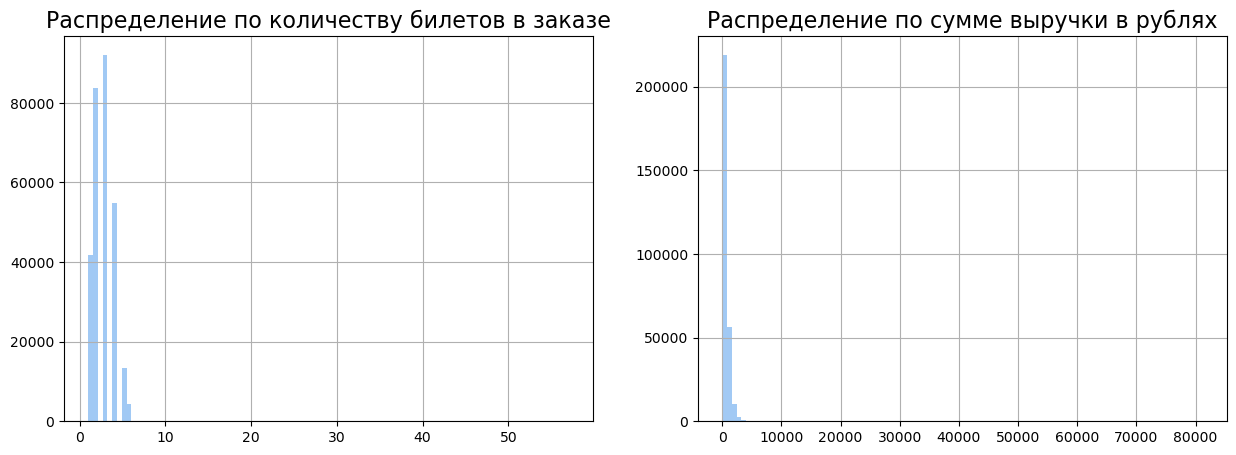

In [30]:
# Построим распределения по показателям
plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 2, 1)
df.tickets_count.hist(bins=100, ax=ax1)
plt.title("Распределение по количеству билетов в заказе", fontsize=16)
ax2 = plt.subplot(1, 2, 2)
df.revenue_rub.hist(bins=100, ax=ax2)
plt.title("Распределение по сумме выручки в рублях", fontsize=16)
plt.show()

Судя по распределению, в данных явно присутствуют аномальные значения по столбцам `tickets_count` и `revenue_rub`.

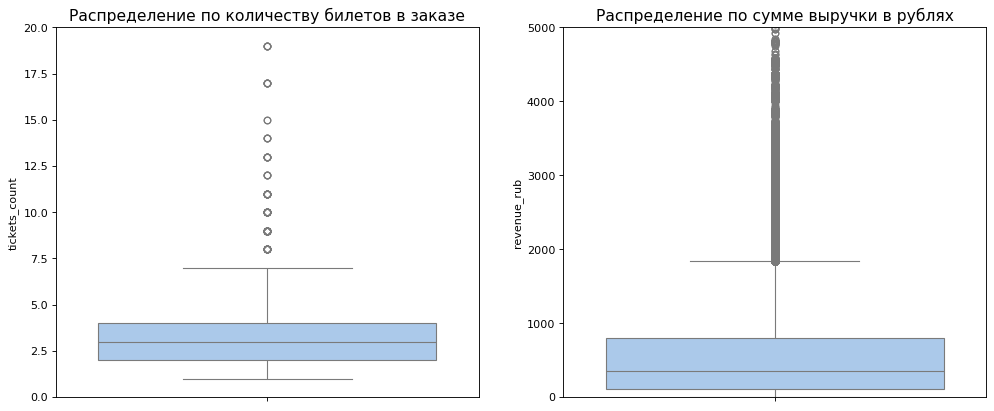

In [31]:
plt.figure(figsize=(15,6), dpi= 80)
ax1 = plt.subplot(1, 2, 1)
sns.boxplot(y='tickets_count', data=df, notch=False, ax=ax1)
plt.title('Распределение по количеству билетов в заказе', fontsize=14)
plt.ylim(0, 20)
ax2 = plt.subplot(1, 2, 2)
sns.boxplot(y='revenue_rub', data=df, notch=False, ax=ax2)
plt.title('Распределение по сумме выручки в рублях', fontsize=14)
plt.ylim(0, 5000)
plt.show()

In [32]:
top_revenue = df.revenue_rub.quantile(.99)

In [33]:
r'После фильтрации массив данных сократится на - {:.1%}'.format(1 - len(df.query("revenue_rub < @top_revenue"))/len(df))

'После фильтрации массив данных сократится на - 1.0%'

In [34]:
# Для правильного нахождения выбросов по выручке, нужно найти удельный показатель выручки на один билет в заказе
df['revenue_one_ticket'] = round(df.revenue_rub/df.tickets_count, 2)

In [35]:
top_revenue_one_ticket = df.revenue_one_ticket.quantile(.99)

In [36]:
r'После фильтрации по удельной выручке массив данных сократится на - {:.1%}'.format(1 - len(df.query("revenue_one_ticket < @top_revenue_one_ticket"))/len(df))

'После фильтрации по удельной выручке массив данных сократится на - 1.0%'

In [37]:
df = df.query("revenue_one_ticket < @top_revenue_one_ticket")

In [38]:
len(df)

287315

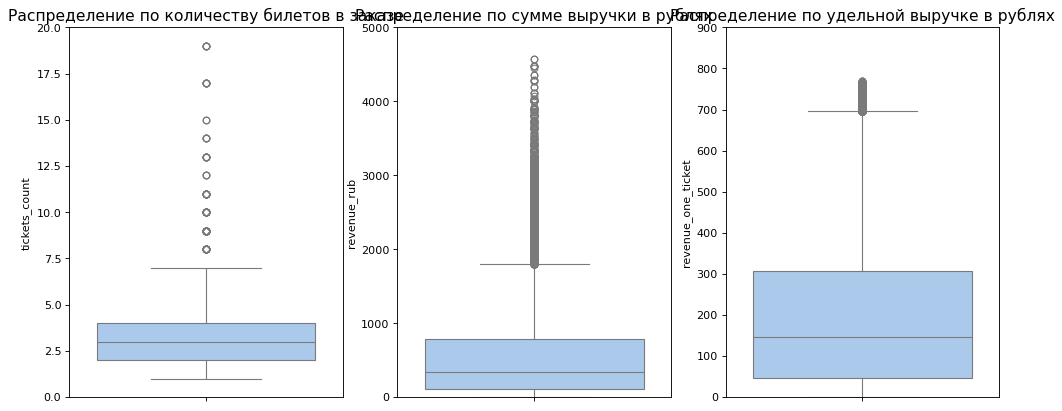

In [39]:
plt.figure(figsize=(15,6), dpi= 80)
ax1 = plt.subplot(1, 3, 1)
sns.boxplot(y='tickets_count', data=df, notch=False, ax=ax1)
plt.title('Распределение по количеству билетов в заказе', fontsize=14)
plt.ylim(0, 20)
ax2 = plt.subplot(1, 3, 2)
sns.boxplot(y='revenue_rub', data=df, notch=False, ax=ax2)
plt.title('Распределение по сумме выручки в рублях', fontsize=14)
plt.ylim(0, 5000)
ax3 = plt.subplot(1, 3, 3)
sns.boxplot(y='revenue_one_ticket', data=df, notch=False, ax=ax3)
plt.title('Распределение по удельной выручке в рублях', fontsize=14)
plt.ylim(0, 900)
plt.show()

In [40]:
r'Минимальное количество билетов в заказе {}, а максимальное - {}'.format(df.tickets_count.min(), df.tickets_count.max())

'Минимальное количество билетов в заказе 1, а максимальное - 57'

In [41]:
# поиск расхождений в данных по дате создания заказа и дате и времени, даты в обоих столбцах должны совпадать
df[df.order_dt != df.order_ts.dt.date]

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub,revenue_one_ticket


In [42]:
df[df.revenue_one_ticket != 0].describe()

,order_dt,order_ts,tickets_count,days_since_prev,revenue_rub,revenue_one_ticket
count,281789,281789,281789.000000,260423.000000,281789.000000,281789.000000
mean,2024-09-02 22:45:27.751615232,2024-09-03 13:41:55.623218432,2.757563,3.253764,533.669738,193.188427
min,2024-06-01 00:00:00,2024-06-01 00:00:42,1.000000,0.000000,0.020000,0.020000
25%,2024-08-01 00:00:00,2024-08-01 00:20:04,2.000000,0.000000,122.610000,49.920000
50%,2024-09-13 00:00:00,2024-09-13 16:57:03,3.000000,0.000000,358.160000,153.130000
75%,2024-10-10 00:00:00,2024-10-10 08:57:52,4.000000,1.000000,797.940000,306.580000
max,2024-10-31 00:00:00,2024-10-31 23:59:54,47.000000,148.000000,4568.400000,769.930000
std,NaN,NaN,1.165786,11.419593,529.122948,161.462528


Часть данных с указанием выручки с заказа представлена в российских рублях, а часть в казахтанских тенге, поэтому для корректного сравнения вся выручка была приведена к валюте - российский рубль, в соответсвии с курсом на дату создания заказа. Произведена провека на неявные дубликаты в номинальных данных, дубликатов обнаружено не было. Проверка на аномальных значения показала, что выбросы присутствуют как в столбце `tickets_count`, так и в столбце `revenue_rub`.  Для исключения аномальных значений был использован расчет 99 персентиля по столбцу `revenue_rub` и фильтрация по этому значению датафрейма (массив данных сокращен на 1%). После исключения выбросов по выручке, диапазон по количеству билетов в одном заказе не изменился. Количесво билетов в одном заказе вполне разумно - это могут быть гурпповые (корпоративные) мероприятия. Основная часть билетов стоит от 49 до 306 руб, средний чек по билету составляет - 153 руб.

## Шаг 3. 
## Создание профиля пользователя.

Построим профиль пользователя — для каждого пользователя найдем:
* дату первого и последнего заказа;
* устройство, с которого был сделан первый заказ;
* регион, в котором был сделан первый заказ;
* билетного партнёра, к которому обращались при первом заказе;
* жанр первого посещённого мероприятия (используйте поле event_type_main );
* общее количество заказов;
* средняя выручка с одного заказа в рублях;
* среднее количество билетов в заказе;
* среднее время между заказами.

In [43]:
df.columns

Index(['user_id', 'device_type_canonical', 'order_id', 'order_dt', 'order_ts',
       'currency_code', 'tickets_count', 'days_since_prev', 'event_id',
       'event_name', 'event_type_main', 'service_name', 'region_name',
       'city_name', 'revenue_rub', 'revenue_one_ticket'],
      dtype='object')

In [44]:
r'Всего пользователей совершили заказ за изучаемый период - {}'.format(df['user_id'].nunique())

'Всего пользователей совершили заказ за изучаемый период - 21809'

In [45]:
df = df.sort_values(by=['user_id','order_ts'])

In [46]:
df.head(3)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub,revenue_one_ticket
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,1521.94,380.48
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,289.45,144.72
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,1258.57,314.64


In [47]:
# Найдем дату последнего заказа
df['dt_last_order'] = df.groupby('user_id')['order_dt'].transform("last")

In [48]:
df.head(3)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub,revenue_one_ticket,dt_last_order
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,1521.94,380.48,2024-08-20
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,289.45,144.72,2024-10-06
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,1258.57,314.64,2024-10-06


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 287315 entries, 0 to 290229
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                287315 non-null  object        
 1   device_type_canonical  287315 non-null  object        
 2   order_id               287315 non-null  object        
 3   order_dt               287315 non-null  datetime64[ns]
 4   order_ts               287315 non-null  datetime64[ns]
 5   currency_code          287315 non-null  object        
 6   tickets_count          287315 non-null  int64         
 7   days_since_prev        265637 non-null  float64       
 8   event_id               287315 non-null  object        
 9   event_name             287315 non-null  object        
 10  event_type_main        287315 non-null  object        
 11  service_name           287315 non-null  object        
 12  region_name            287315 non-null  object   

In [50]:
# Найдем:
# дату первого заказа;
# устройство, с которого был сделан первый заказ;
# регион, в котором был сделан первый заказ;
# билетного партнёра, к которому обращались при первом заказе;
# жанр первого посещённого мероприятия:

def first_value(column):
    return df.groupby('user_id')[column].transform("first")

df['dt_first_order'] = first_value('order_dt')
df['device_type_first'] = first_value('device_type_canonical')
df['region_name_first'] = first_value('region_name')
df['service_name_first'] = first_value('service_name')
df['event_type_main_first'] = first_value('event_type_main')

In [51]:
# Найдем:
# общее количество заказов;
# средняя выручка с одного заказа в рублях;
# среднее количество билетов в заказе;
# среднее время между заказами.

df['order_count'] = df.groupby('user_id')['order_id'].transform("count")
def mean_value(column):
    return round(df.groupby('user_id')[column].transform("mean"), 0)
df['revenue_mean'] = mean_value('revenue_rub')
df['tickets_count_mean'] = mean_value('tickets_count')
df['days_since_prev_mean'] = mean_value('days_since_prev')

In [52]:
df.head(5)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,tickets_count,days_since_prev,event_id,event_name,...,dt_last_order,dt_first_order,device_type_first,region_name_first,service_name_first,event_type_main_first,order_count,revenue_mean,tickets_count_mean,days_since_prev_mean
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,...,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1522.0,4.0,NaN
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,...,2024-10-06,2024-07-23,mobile,Каменевский регион,Мой билет,выставки,2,774.0,3.0,75.0
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,...,2024-10-06,2024-07-23,mobile,Каменевский регион,Мой билет,выставки,2,774.0,3.0,75.0
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,...,2024-10-23,2024-07-13,mobile,Североярская область,Лови билет!,другое,3,767.0,3.0,51.0
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,...,2024-10-23,2024-07-13,mobile,Североярская область,Лови билет!,другое,3,767.0,3.0,51.0


In [53]:
# Добавим два бинарных признака:
# is_two — совершил ли пользователь 2 и более заказа;
# is_five — совершил ли пользователь 5 и более заказов
df.loc[df.order_count >= 2, 'is_two'] = 1
df.loc[df.order_count >= 5, 'is_five'] = 1
df.is_two = df.is_two.fillna(0)
df.is_five = df.is_five.fillna(0)

In [54]:
r'Доля пользователей совершивших 2 и более заказов - {:.0%}'.format(df[['user_id','is_two']].drop_duplicates().is_two.mean())

'Доля пользователей совершивших 2 и более заказов - 62%'

In [55]:
r'Доля пользователей совершивших 5 и более заказов - {:.0%}'.format(df[['user_id','is_five']].drop_duplicates().is_five.mean())

'Доля пользователей совершивших 5 и более заказов - 29%'

In [56]:
df.columns

Index(['user_id', 'device_type_canonical', 'order_id', 'order_dt', 'order_ts',
       'currency_code', 'tickets_count', 'days_since_prev', 'event_id',
       'event_name', 'event_type_main', 'service_name', 'region_name',
       'city_name', 'revenue_rub', 'revenue_one_ticket', 'dt_last_order',
       'dt_first_order', 'device_type_first', 'region_name_first',
       'service_name_first', 'event_type_main_first', 'order_count',
       'revenue_mean', 'tickets_count_mean', 'days_since_prev_mean', 'is_two',
       'is_five'],
      dtype='object')

In [57]:
df_profile = df[['user_id','dt_first_order','dt_last_order', 'device_type_first', 'region_name_first',
       'service_name_first', 'event_type_main_first', 'order_count',
       'revenue_mean', 'tickets_count_mean', 'days_since_prev_mean', 'is_two',
       'is_five']].drop_duplicates()

In [58]:
len(df_profile)

21809

In [59]:
df_profile.describe()

,dt_first_order,dt_last_order,order_count,revenue_mean,tickets_count_mean,days_since_prev_mean,is_two,is_five
count,21809,21809,21809.000000,21809.000000,21809.000000,13495.000000,21809.000000,21809.000000
mean,2024-08-10 01:28:12.787381248,2024-09-18 11:01:12.135356928,13.174148,547.391169,2.758311,15.900333,0.617727,0.290752
min,2024-06-01 00:00:00,2024-06-01 00:00:00,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2024-06-25 00:00:00,2024-08-25 00:00:00,1.000000,213.000000,2.000000,1.000000,0.000000,0.000000
50%,2024-08-09 00:00:00,2024-10-03 00:00:00,2.000000,467.000000,3.000000,8.000000,1.000000,0.000000
75%,2024-09-23 00:00:00,2024-10-22 00:00:00,5.000000,765.000000,3.000000,20.000000,1.000000,1.000000
max,2024-10-31 00:00:00,2024-10-31 00:00:00,10153.000000,4286.000000,11.000000,148.000000,1.000000,1.000000
std,NaN,NaN,121.565309,441.098022,0.953213,22.398434,0.485954,0.454120


In [60]:
df_profile[df_profile.order_count== df_profile.order_count.max()]

,user_id,dt_first_order,dt_last_order,device_type_first,region_name_first,service_name_first,event_type_main_first,order_count,revenue_mean,tickets_count_mean,days_since_prev_mean,is_two,is_five
14647,0beb8fc0c0a9ce1,2024-06-01,2024-10-31,mobile,Североярская область,Билеты в руки,концерты,10153,509.0,3.0,0.0,1.0,1.0


In [61]:
df_user_max = df.query('user_id == "0beb8fc0c0a9ce1"').groupby('order_dt').agg({'order_id':'count','tickets_count':'sum','revenue_rub':'sum'}).reset_index().\
rename(columns={'order_dt':'Дата заказа пользователя 0beb8fc0c0a9ce1','order_id':'Кол-во заказов в день',\
                'tickets_count':'Количество купленных билетов в день','revenue_rub':'Общая сумма выручки в день'})
df_user_max

,Дата заказа пользователя 0beb8fc0c0a9ce1,Кол-во заказов в день,Количество купленных билетов в день,Общая сумма выручки в день
0,2024-06-01,55,161,41318.37
1,2024-06-02,37,105,23409.16
2,2024-06-03,33,91,15994.28
3,2024-06-04,20,56,8182.46
4,2024-06-05,32,85,17211.99
...,...,...,...,...
148,2024-10-27,102,308,46616.01
149,2024-10-28,137,382,56258.41
150,2024-10-29,98,298,44406.72
151,2024-10-30,122,338,58815.78


In [62]:
df.order_dt.max() - df.order_dt.min()

Timedelta('152 days 00:00:00')

In [63]:
r'Пользователь с ID `0beb8fc0c0a9ce1` совершал заказы каждый день. Среднее количество заказов в сутки для этого пользователя составило {},количество билетов в сутки в среднем - {}, со средней суммой выручки в сутки - {}.'\
.format(round(df_user_max['Кол-во заказов в день'].mean(),0).astype('int'),\
        round(df_user_max['Количество купленных билетов в день'].mean(),0).astype('int'),\
        round(df_user_max['Общая сумма выручки в день'].mean(),0).astype('int'))

'Пользователь с ID `0beb8fc0c0a9ce1` совершал заказы каждый день. Среднее количество заказов в сутки для этого пользователя составило 66,количество билетов в сутки в среднем - 191, со средней суммой выручки в сутки - 33796.'

Исключим этого пользователя из анализа, так как это может исказить результаты исследования.

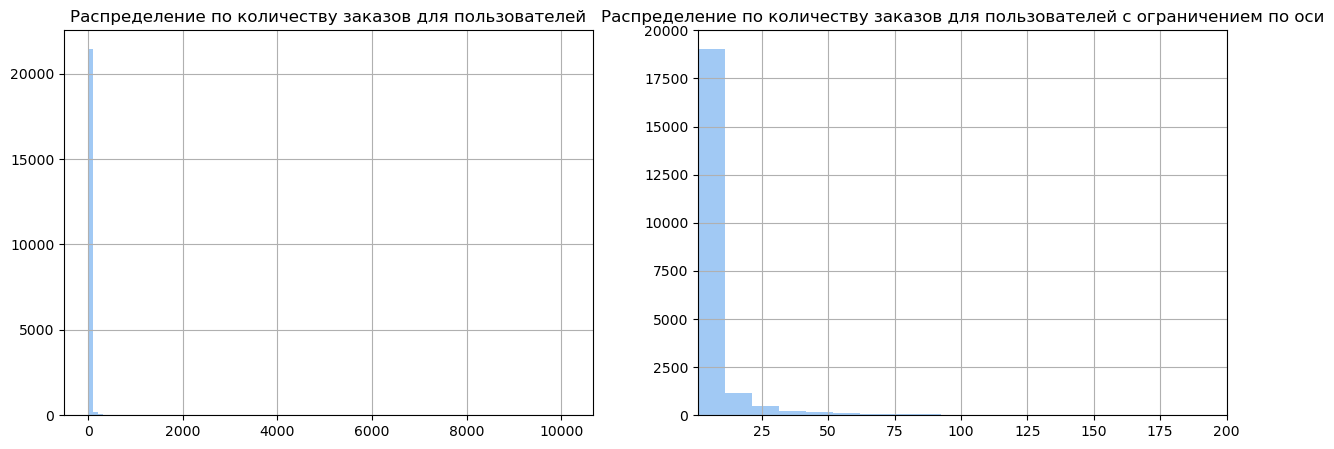

In [64]:
# задаём размер сетки для графиков
plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 2, 1)
df_profile.order_count.hist(bins=100, ax=ax1)
plt.title("Распределение по количеству заказов для пользователей", fontsize=12)
ax2 = plt.subplot(1, 2, 2)
df_profile.order_count.hist(bins=1000, ax=ax2)
plt.title("Распределение по количеству заказов для пользователей с ограничением по оси", fontsize=12)
plt.xlim(1,200)
plt.show()

In [65]:
df_profile.columns

Index(['user_id', 'dt_first_order', 'dt_last_order', 'device_type_first',
       'region_name_first', 'service_name_first', 'event_type_main_first',
       'order_count', 'revenue_mean', 'tickets_count_mean',
       'days_since_prev_mean', 'is_two', 'is_five'],
      dtype='object')

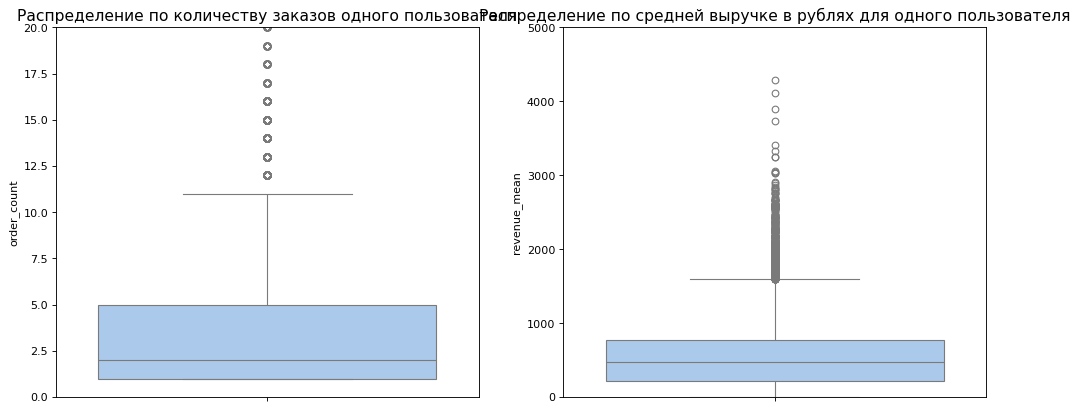

In [66]:
plt.figure(figsize=(15,6), dpi= 80)
ax1 = plt.subplot(1, 2, 1)
sns.boxplot(y='order_count', data=df_profile, notch=False, ax=ax1)
plt.title('Распределение по количеству заказов одного пользователя', fontsize=14)
plt.ylim(0, 20)
ax2 = plt.subplot(1, 2, 2)
sns.boxplot(y='revenue_mean', data=df_profile, notch=False, ax=ax2)
plt.title('Распределение по средней выручке в рублях для одного пользователя', fontsize=14)
plt.ylim(0, 5000)
plt.show()

Примем аномальные значения количества заказов для одного пользователя, как нетипичное поведение пользователей. Например билеты могут скупать агенты, с целью перепродажи билетов. Такие данные могут искажать результаты исследований о поведении пользователей.

In [67]:
r'95-й персентиль для поля order_count составит {}, 99-й персентиль для поля order_count составит {}'.\
format(df_profile.order_count.quantile(.95),df_profile.order_count.quantile(.99))

'95-й персентиль для поля order_count составит 32.0, 99-й персентиль для поля order_count составит 152.0'

Значение 99-го персетиля для количесва заказов для одного пользователя - 152, а это значит, что такой пользователь за указанный период совершает заказ каждый день, в данном случае целесообразнее отфильтровать пользователей по количеству заказов не превышающего 32. Обычный пользователь не совершит большее число заказов за такой короткий период.

In [68]:
top_order_count = df_profile.order_count.quantile(.95)

In [69]:
r'После фильтрации массив данных сократится на - {:.1%}'.format(1 - len(df_profile.query("order_count < @top_order_count"))/len(df_profile))

'После фильтрации массив данных сократится на - 5.0%'

In [70]:
df_profile = df_profile.query("order_count < @top_order_count")

In [71]:
df_profile.user_id.nunique()

20716

После фильтрации в выборке остались пользовательские профили по 20 716 уникальным пользователям.

In [72]:
df_profile.describe()

,dt_first_order,dt_last_order,order_count,revenue_mean,tickets_count_mean,days_since_prev_mean,is_two,is_five
count,20716,20716,20716.000000,20716.000000,20716.000000,12402.000000,20716.000000,20716.000000
mean,2024-08-13 07:14:18.466885376,2024-09-16 08:50:26.530218240,4.048658,549.551603,2.752800,17.113208,0.597557,0.253331
min,2024-06-01 00:00:00,2024-06-01 00:00:00,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2024-07-01 00:00:00,2024-08-22 00:00:00,1.000000,202.000000,2.000000,1.000000,0.000000,0.000000
50%,2024-08-14 00:00:00,2024-10-01 00:00:00,2.000000,457.000000,3.000000,10.000000,1.000000,0.000000
75%,2024-09-25 00:00:00,2024-10-20 00:00:00,5.000000,782.000000,3.000000,22.000000,1.000000,1.000000
max,2024-10-31 00:00:00,2024-10-31 00:00:00,31.000000,4286.000000,11.000000,148.000000,1.000000,1.000000
std,NaN,NaN,5.105732,450.705664,0.973486,22.969348,0.490402,0.434929


Теперь можно изучать статистические показатели выборки. Среднее количество заказов, совершаемых пользователями - 2, средняя выручка с одного пользователя - 549 руб., среднее количество билетов в одном заказе - 3, среднее кол-во дней с предыдущего заказа - 17 дней. 2 или более заказов совершили 60 % пользователей, 5 или более заказов совершили 25 % пользователей.

## Шаг 4. 
## Исследовательский анализ данных.

### **4.1. Исследование признаков первого заказа и их связи с возвращением на платформу**

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа.

Изучим распределение пользователей по признакам.

Сгруппируйте пользователей:
* по типу их первого мероприятия;
* по типу устройства, с которого совершена первая покупка;
* по региону проведения мероприятия из первого заказа;
* по билетному оператору, продавшему билеты на первый заказ.

Подсчитаем общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
Ответим на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

In [73]:
df_profile.columns

Index(['user_id', 'dt_first_order', 'dt_last_order', 'device_type_first',
       'region_name_first', 'service_name_first', 'event_type_main_first',
       'order_count', 'revenue_mean', 'tickets_count_mean',
       'days_since_prev_mean', 'is_two', 'is_five'],
      dtype='object')

In [74]:
df_profile.groupby('device_type_first').agg({'user_id':'count'})

,user_id
device_type_first,
desktop,3534
mobile,17182


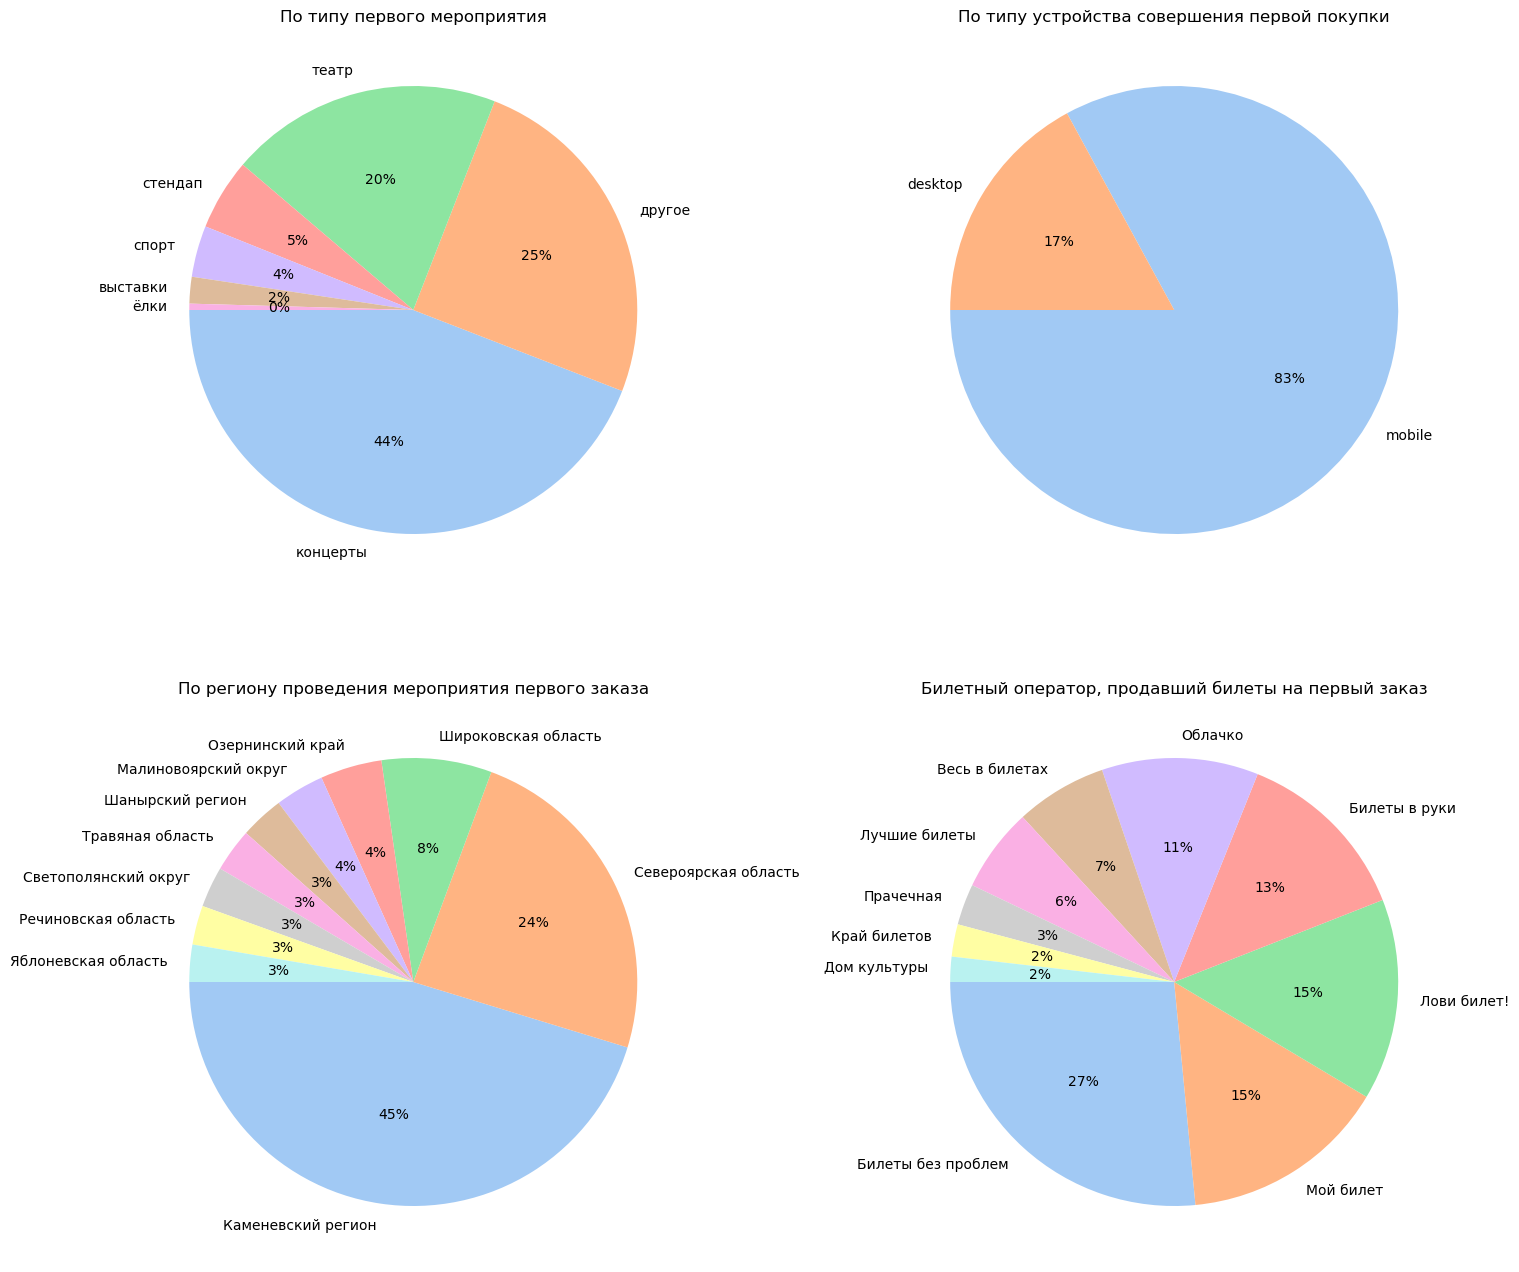

In [75]:
plt.figure(figsize=(18, 16))
colors = sns.color_palette('pastel')[0:10]
j=1
for segment, title in zip(
    ('event_type_main_first', 'device_type_first', 'region_name_first','service_name_first'),
    ('По типу первого мероприятия', 'По типу устройства совершения первой покупки',
     'По региону проведения мероприятия первого заказа','Билетный оператор, продавший билеты на первый заказ')
):
    pivot = df_profile.groupby(segment).agg({'user_id':'count'}).reset_index().sort_values('user_id', ascending=False)
    ax = plt.subplot(2, 2, j)
    ax.pie(x=pivot['user_id'].head(10), labels=pivot[segment].head(10), autopct='%.0f%%', colors=colors, startangle = 180)
    plt.title(title)
    j += 1

Сегменты были ограничены топ-10 самыми объемными по количеству пользователей. В основном первые заказы совершены с мобильных телефонов, на концерты, театры и другие мероприятия. Активные заказчики проживают в Каменевском регионе и Североярской области. Самый крупный оператор по продаже билетов - `Билеты без проблем`, через этого оператора совершили первый заказ 27% пользователей.

Проанализируем возвраты пользователей:
* Для каждого сегмента вычислим долю пользователей, совершивших два и более заказа.
* Визуализируем результат подходящим графиком.
Ответим на вопросы:
* Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
* Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?
* При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

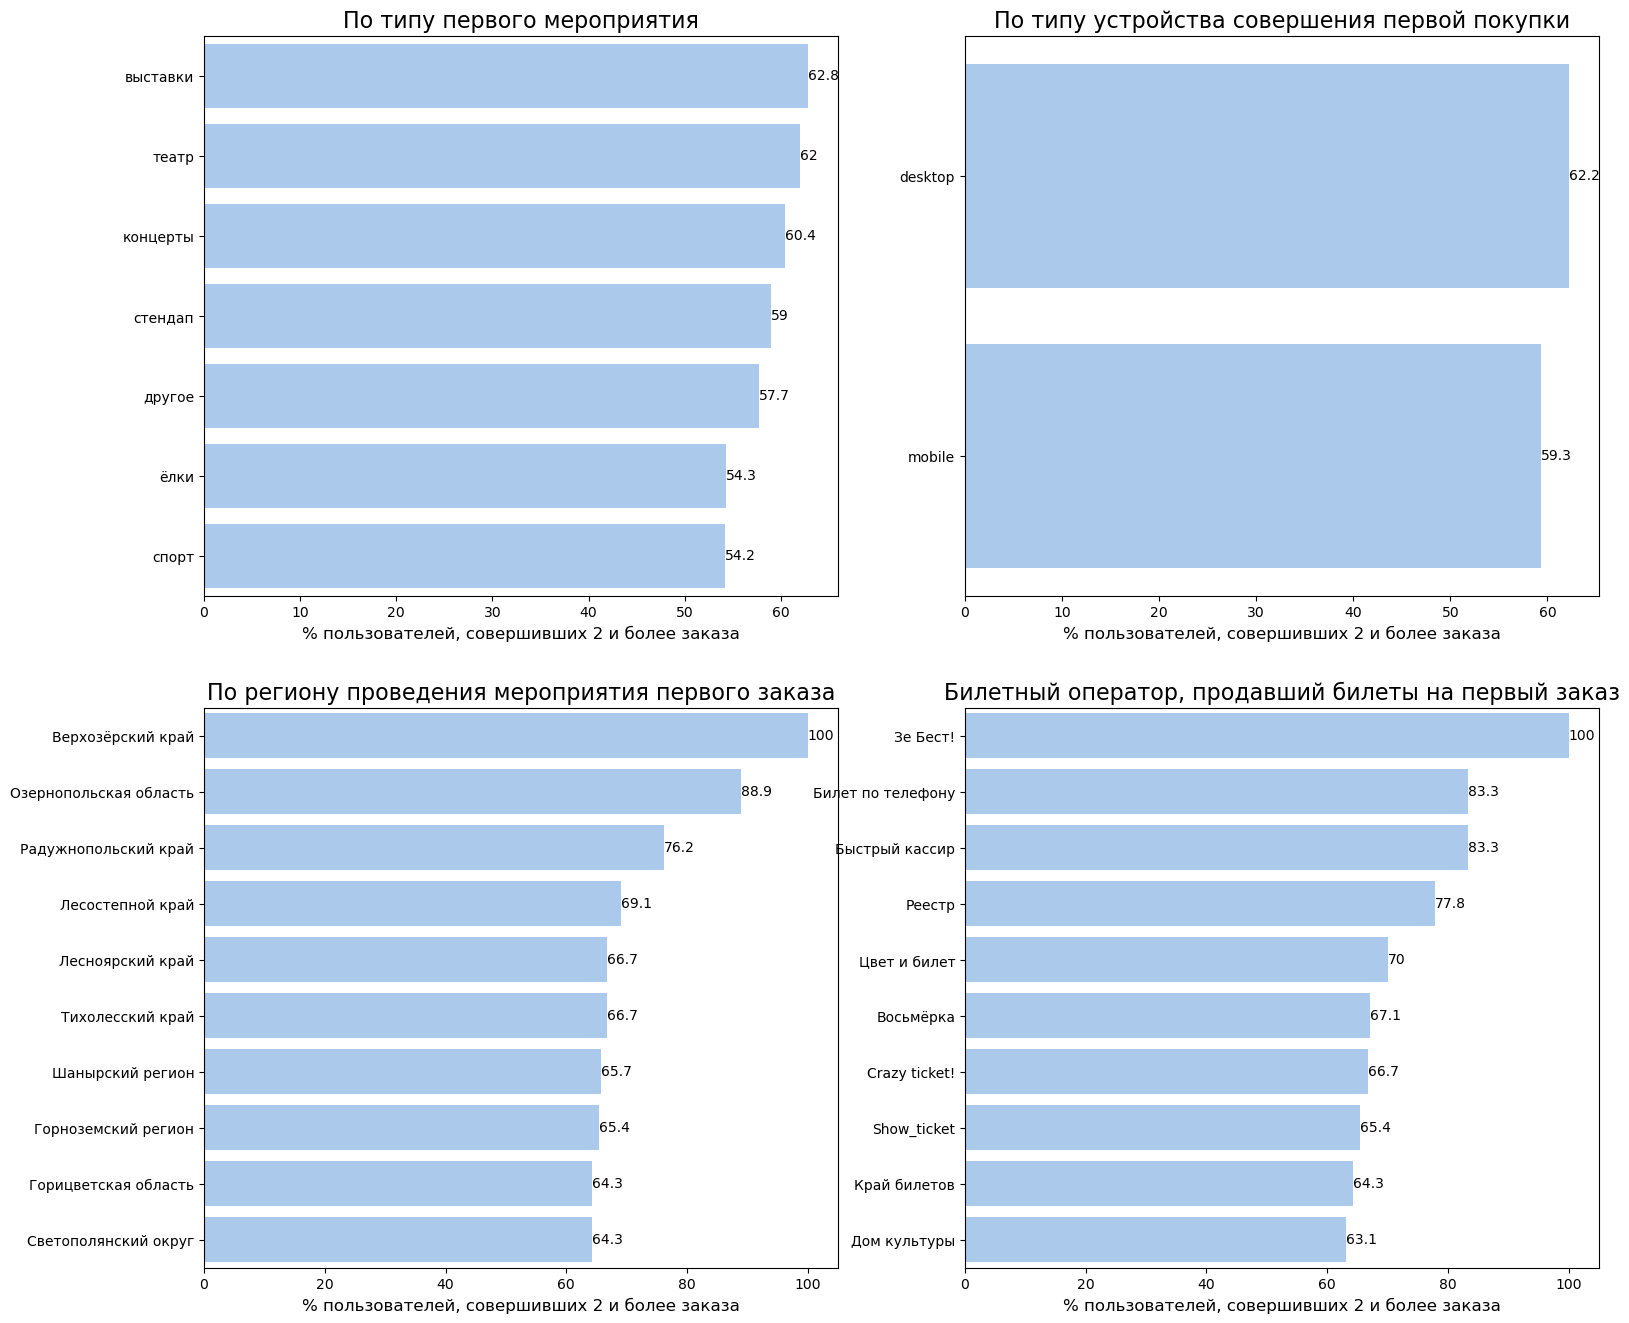

In [76]:
plt.figure(figsize=(18, 16))
j=1
for segment, title in zip(
    ('event_type_main_first', 'device_type_first', 'region_name_first','service_name_first'),
    ('По типу первого мероприятия', 'По типу устройства совершения первой покупки',
     'По региону проведения мероприятия первого заказа','Билетный оператор, продавший билеты на первый заказ')
):
    pivot = df_profile.groupby(segment).agg({'is_two':'mean'}).sort_values('is_two', ascending=False).head(10)
    pivot['is_two'] = round(pivot['is_two']*100,1)
    ax = plt.subplot(2, 2, j)
    ax = sns.barplot(x=pivot['is_two'],y=pivot.index)
    ax.bar_label(ax.containers[0], fontsize=10)
    plt.title(title, fontsize=16)
    plt.xlabel("% пользователей, совершивших 2 и более заказа", fontsize=12)
    plt.ylabel("")
    j += 1

По типу мероприятия доля совершивших 2 и более заказа распределены достаточно равномерно 54-63%. По типу устройства совершения первой покупки аналогичная ситуация, для пользователй, совершивших первую покупку с ПК доля возвратов чуть выше, это может быть обусловлено тем, что количество таких пользователей существенно меньше, поэтому разницу нельзя считать существенной.

In [77]:
group_by_region = df_profile.groupby('region_name_first').agg({'user_id':'count'}).reset_index().sort_values('user_id', ascending=False)
group_by_region[group_by_region['region_name_first'].isin(['Верхозёрский край','Озернопольская область', 'Радужнопольский край','Лесостепной край'])]

,region_name_first,user_id
36,Лесостепной край,55
46,Озернопольская область,27
51,Радужнопольский край,21
5,Верхозёрский край,1


Высокая доля возвратов по региону проведения мероприятия  в Верхозерском крае, Озернопольскоой области и Радужнопольском крае.

In [78]:
r'Доля пользователей в Озернопольском районе от общего количества составляет {:.2%}, в Радужнопольском - {:.1%}, в Верхозерском 1 пользователь - {:.3%}'\
.format(group_by_region['user_id'][46]/len(df_profile), group_by_region['user_id'][51]/len(df_profile),group_by_region['user_id'][5]/len(df_profile))

'Доля пользователей в Озернопольском районе от общего количества составляет 0.13%, в Радужнопольском - 0.1%, в Верхозерском 1 пользователь - 0.005%'

Наиболее успешные регионы, в которых пользователи чаще совершали повторный заказ, чем в среднем по выборке обусловлены недосточной репрезентативностью данных.

In [79]:
group_by_service = df_profile.groupby('service_name_first').agg({'user_id':'count'}).reset_index().sort_values('user_id', ascending=False)
group_by_service[group_by_service['service_name_first'].isin(['Зе Бест!','Билет по телефону', 'Быстрый кассир','Реестр','Цвет и билет','Восьмёрка'])]

,service_name_first,user_id
8,Восьмёрка,82
6,Быстрый кассир,54
26,Реестр,27
31,Цвет и билет,20
2,Билет по телефону,6
14,Зе Бест!,1


Аналогичная картина сложилась в сегменте оператора, продавшего билеты на первый заказ.
Рассмотрим сегменты с наименьшей долей пользователей, совершивших два и более заказа.

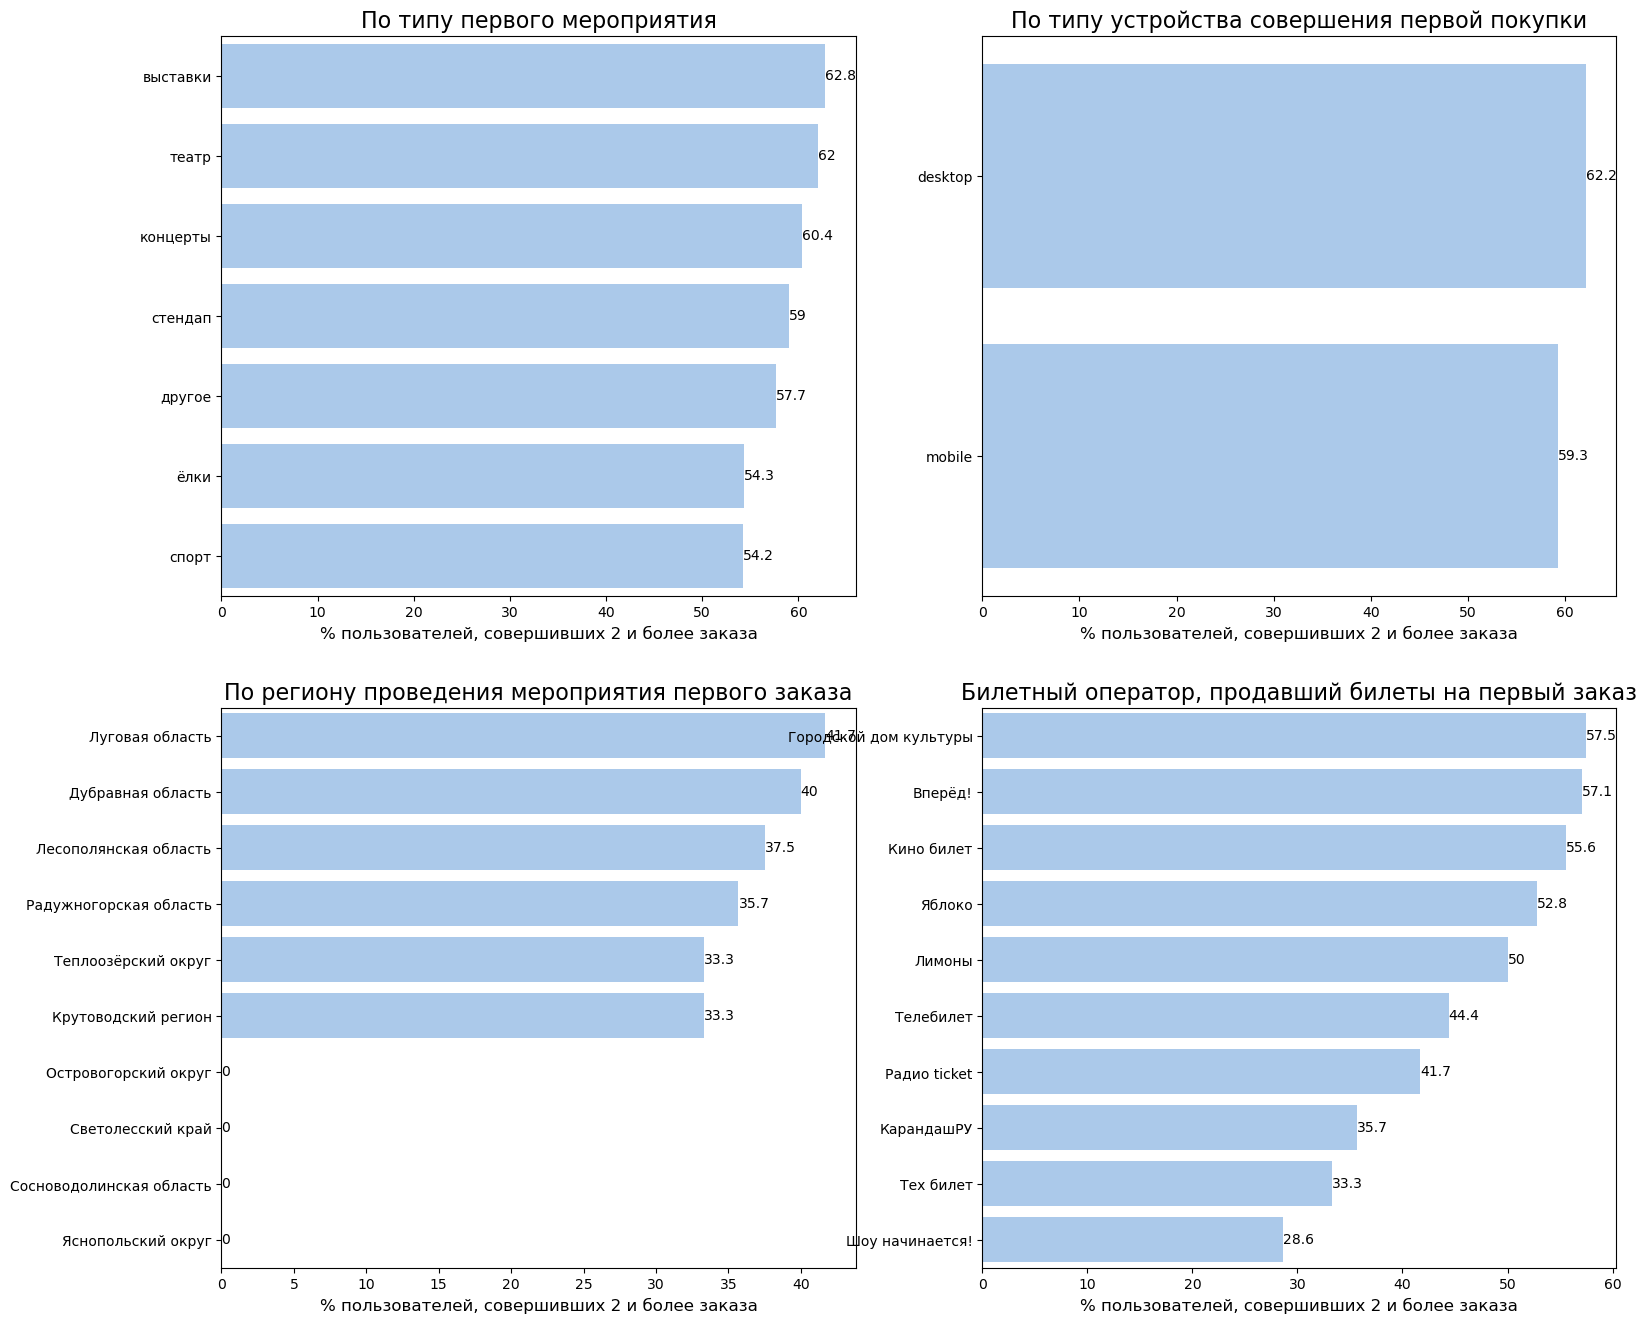

In [80]:
plt.figure(figsize=(18, 16))
j=1
for segment, title in zip(
    ('event_type_main_first', 'device_type_first', 'region_name_first','service_name_first'),
    ('По типу первого мероприятия', 'По типу устройства совершения первой покупки',
     'По региону проведения мероприятия первого заказа','Билетный оператор, продавший билеты на первый заказ')
):
    pivot = df_profile.groupby(segment).agg({'is_two':'mean'}).sort_values('is_two', ascending=False).tail(10)
    pivot['is_two'] = round(pivot['is_two']*100,1)
    ax = plt.subplot(2, 2, j)
    ax = sns.barplot(x=pivot['is_two'],y=pivot.index)
    ax.bar_label(ax.containers[0], fontsize=10)
    plt.title(title, fontsize=16)
    plt.xlabel("% пользователей, совершивших 2 и более заказа", fontsize=12)
    plt.ylabel("")
    j += 1

In [81]:
group_by_region[group_by_region['region_name_first'].isin(['Яснопольский округ','Сосноводолиская область', 'Светолесский край','Островогорский округ',\
                                                          'Крутоводский регион','Теплоозёрский округ','Радужногорская область','Лесополянская область',\
                                                          'Дубравная область','Луговая область'])]

,region_name_first,user_id
38,Луговая область,36
50,Радужногорская область,14
35,Лесополянская область,8
16,Дубравная область,5
48,Островогорский округ,4
32,Крутоводский регион,3
68,Теплоозёрский округ,3
56,Светолесский край,1
80,Яснопольский округ,1


In [82]:
group_by_service[group_by_service['service_name_first'].isin(['Шоу начинается','Тех билет', 'КарандашРУ','Радио ticket','Лимоны',\
                                                              'Яблоко','Кино билет','Вперёд!','Городской дом культуры'])]

,service_name_first,user_id
33,Яблоко,309
11,Городской дом культуры,212
25,Радио ticket,36
15,КарандашРУ,14
16,Кино билет,9
9,Вперёд!,7
30,Тех билет,3
18,Лимоны,2


Низкие и высокие значения доли пользователей совершивших два и более заказа обусловлены количеством данных в выборке.

Проверим продуктовые гипотезы:
* Гипотеза 1. Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
* Гипотеза 2. В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

In [83]:
group_by_event_type = df_profile.groupby('event_type_main_first').agg({'is_two':'mean'}).sort_values('is_two', ascending=False).reset_index()
group_by_event_type

,event_type_main_first,is_two
0,выставки,0.628141
1,театр,0.620402
2,концерты,0.603786
3,стендап,0.590440
4,другое,0.576953
5,ёлки,0.542553
6,спорт,0.541667


In [84]:
r'Доля пользователей, которые совершили первый заказ на спортивные мероприятия, совершивший повторный заказ составляет {:.1%}, а среди пользователей,     оформивших свой первый заказ на концерты, возвращались за повторным заказом {:.1%}'\
.format(group_by_event_type[group_by_event_type.event_type_main_first == 'спорт']['is_two'].values[0],\
        group_by_event_type[group_by_event_type.event_type_main_first == 'концерты']['is_two'].values[0])

'Доля пользователей, которые совершили первый заказ на спортивные мероприятия, совершивший повторный заказ составляет 54.2%, а среди пользователей,     оформивших свой первый заказ на концерты, возвращались за повторным заказом 60.4%'

Нельзя подтвердить гипотезу о том, что пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.

<Axes: >

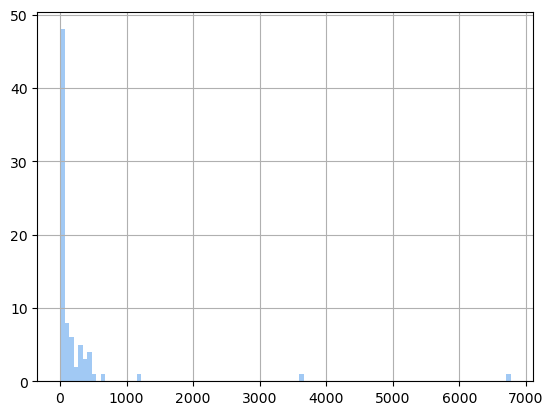

In [85]:
group_by_region['user_id'].hist(bins=100)
#plt.xlim(0, 1000)

Примем за активные регионы с количеством пользователей, совершивших заказ, более 1000. Остальные регионы менее активные.

In [86]:
print(len(group_by_region.query('user_id > 1000')['user_id']))
print(len(group_by_region.query('user_id <= 1000')['user_id']))

3
78


In [87]:
group_by_region_is_two = df_profile.groupby('region_name_first').agg({'is_two':'mean'}).sort_values('is_two', ascending=False).reset_index()

In [88]:
(
    group_by_region_is_two[group_by_region_is_two['region_name_first'].
    isin(group_by_region.query('user_id > 1000')['region_name_first'].
         tolist())]['is_two'].mean()
)

np.float64(0.6213355328612366)

In [89]:
(
    group_by_region_is_two[group_by_region_is_two['region_name_first'].
    isin(group_by_region.query('user_id < 1000')['region_name_first'].
         tolist())]['is_two'].mean()
)

np.float64(0.5295970913176055)

In [90]:
alpha = 0.05
sample_1 = group_by_region_is_two[group_by_region_is_two['region_name_first'].\
isin(group_by_region.query('user_id > 1000')['region_name_first'].tolist())]['is_two']
sample_2 = group_by_region_is_two[group_by_region_is_two['region_name_first'].\
isin(group_by_region.query('user_id <= 1000')['region_name_first'].tolist())]['is_two']

In [91]:
results = st.ttest_ind(
    sample_1, 
    sample_2, 
    equal_var = False)

print('p-значение:', results.pvalue)

p-значение: 2.1367606919680468e-05


In [92]:
# отвергаем гипотезу только тогда, когда выборочное среднее выборки с пользователями тарифа Ультра значимо превышает
if (results.pvalue / 2 < alpha) and (sample_1.mean() > sample_2.mean()):                 # выборочное среднее выборки
    print("Отвергаем нулевую гипотезу")                                                  # с пользователями тарифа Смарт
else:
    print("Не отвергаем нулевую гипотезу") 

Отвергаем нулевую гипотезу


Не получилось подтвердить ни одну из поставленных гипотез, при уменьшении порога числа пользователей для признания региона активным получаются аналогичные результаты.

### **4.2. Исследование поведения пользователей через показатели выручки и состава заказа**

Проследим связь между средней выручкой сервиса с заказа и повторными заказами.

Построим сравнительные гистограммы распределения средней выручки с билета:
* для пользователей, совершивших один заказ;
* для вернувшихся пользователей, совершивших 2 и более заказа.

Ответим на вопросы: 
* В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
* Есть ли различия между группами?

In [93]:
df_profile.columns

Index(['user_id', 'dt_first_order', 'dt_last_order', 'device_type_first',
       'region_name_first', 'service_name_first', 'event_type_main_first',
       'order_count', 'revenue_mean', 'tickets_count_mean',
       'days_since_prev_mean', 'is_two', 'is_five'],
      dtype='object')

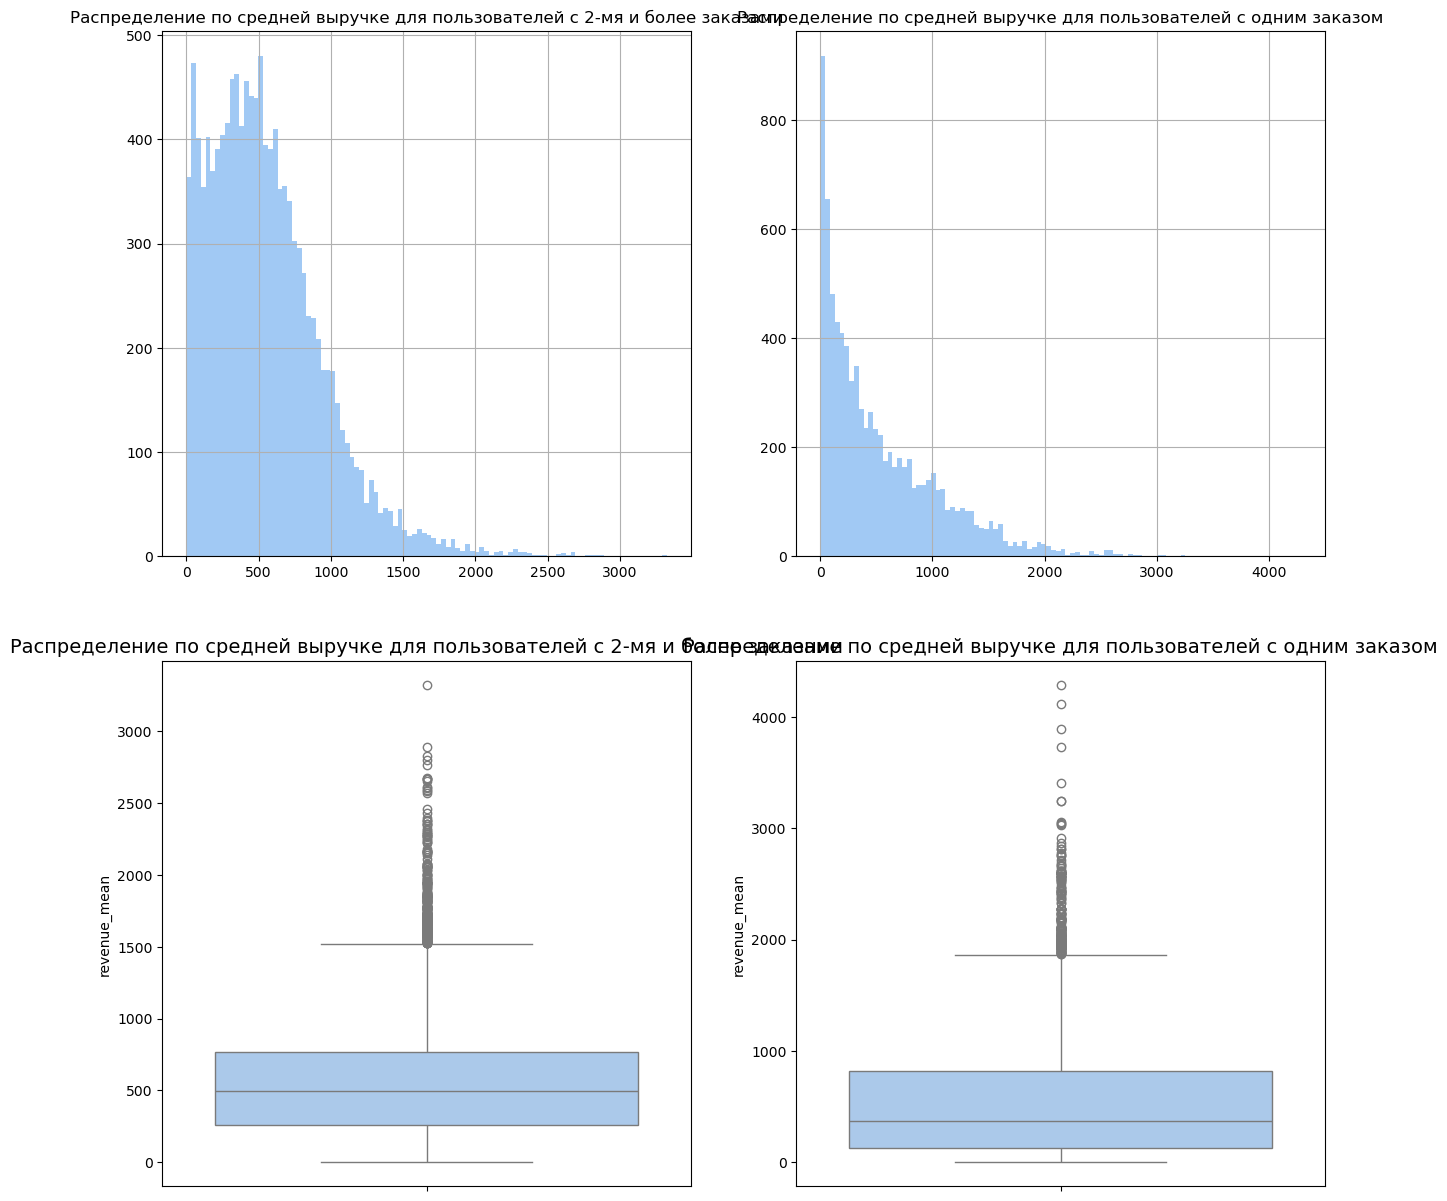

In [94]:
plt.figure(figsize=(15, 15))
ax1 = plt.subplot(2, 2, 1)
df_profile[df_profile.is_two == 1].revenue_mean.hist(bins=100, ax=ax1)
plt.title("Распределение по средней выручке для пользователей с 2-мя и более заказами", fontsize=12)
ax2 = plt.subplot(2, 2, 2)
df_profile[df_profile.is_two == 0].revenue_mean.hist(bins=100, ax=ax2)
plt.title("Распределение по средней выручке для пользователей с одним заказом", fontsize=12)
ax3 = plt.subplot(2, 2, 3)
sns.boxplot(y='revenue_mean', data=df_profile[df_profile.is_two == 1], notch=False, ax=ax3)
plt.title('Распределение по средней выручке для пользователей с 2-мя и более заказами', fontsize=14)
ax4 = plt.subplot(2, 2, 4)
sns.boxplot(y='revenue_mean', data=df_profile[df_profile.is_two == 0], notch=False, ax=ax4)
plt.title('Распределение по средней выручке для пользователей с одним заказом', fontsize=14)
#plt.ylim(0, 5000)
plt.show()

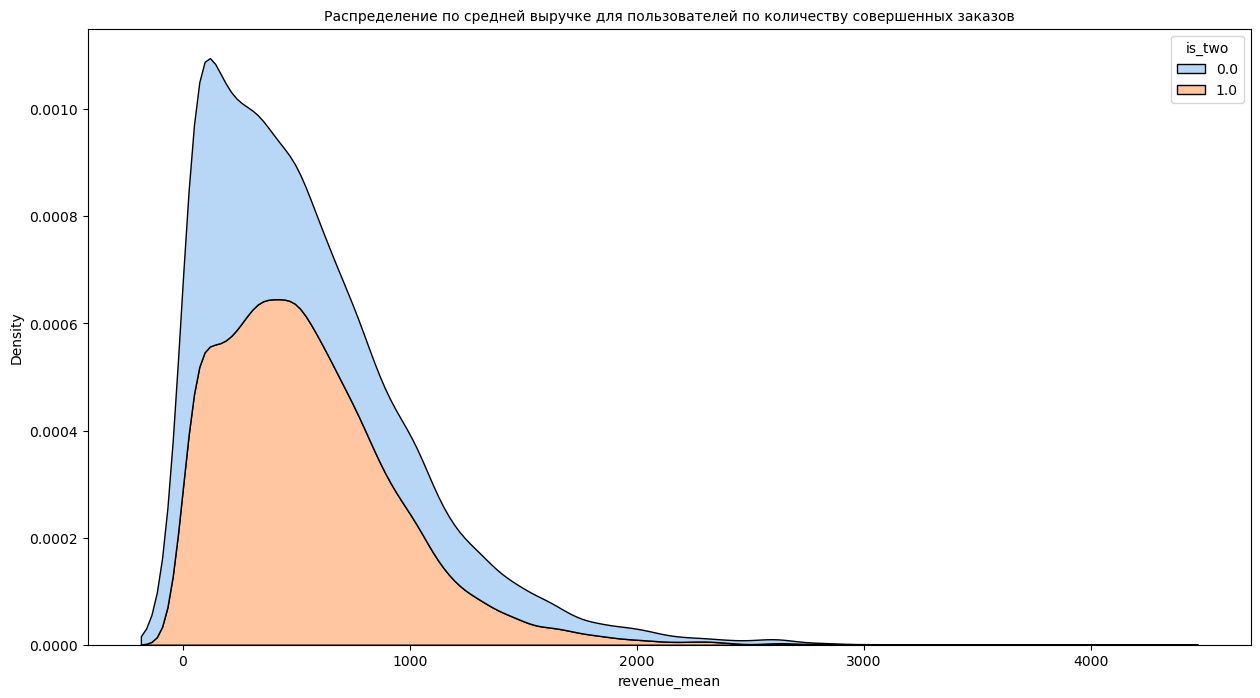

In [95]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.kdeplot(x='revenue_mean',
            hue='is_two',
            multiple='stack',
            data=df_profile, ax=ax)
plt.title("Распределение по средней выручке для пользователей по количеству совершенных заказов", fontsize=10)
plt.show()

In [96]:
r'Средняя выручка для пользователей, совершивших два и более заказа находится в диапазоне от {} - {}, а среди пользователей с одним заказом - {} - {}'\
.format(df_profile[df_profile.is_two == 1].revenue_mean.quantile(0.25),\
        df_profile[df_profile.is_two == 1].revenue_mean.quantile(0.75),\
        df_profile[df_profile.is_two == 0].revenue_mean.quantile(0.25),\
        df_profile[df_profile.is_two == 0].revenue_mean.quantile(0.75))

'Средняя выручка для пользователей, совершивших два и более заказа находится в диапазоне от 261.0 - 766.0, а среди пользователей с одним заказом - 132.0 - 824.0'

Исходя из полученных распределений нельзя утверждать, что пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются. У пользователей, которые совершили один заказ диапазон средней выручки шире, чем для пользователей, которые повторно воспользовались сервисом. Тем не менее пик гистограммы для вернувшихся пользователей смещен в большую сторону от вершины распределения для пользователей с одним заказом.

Сравним распределение по средней выручке с заказа в двух группах пользователей:
* совершившие 2–4 заказа;
* совершившие 5 и более заказов.

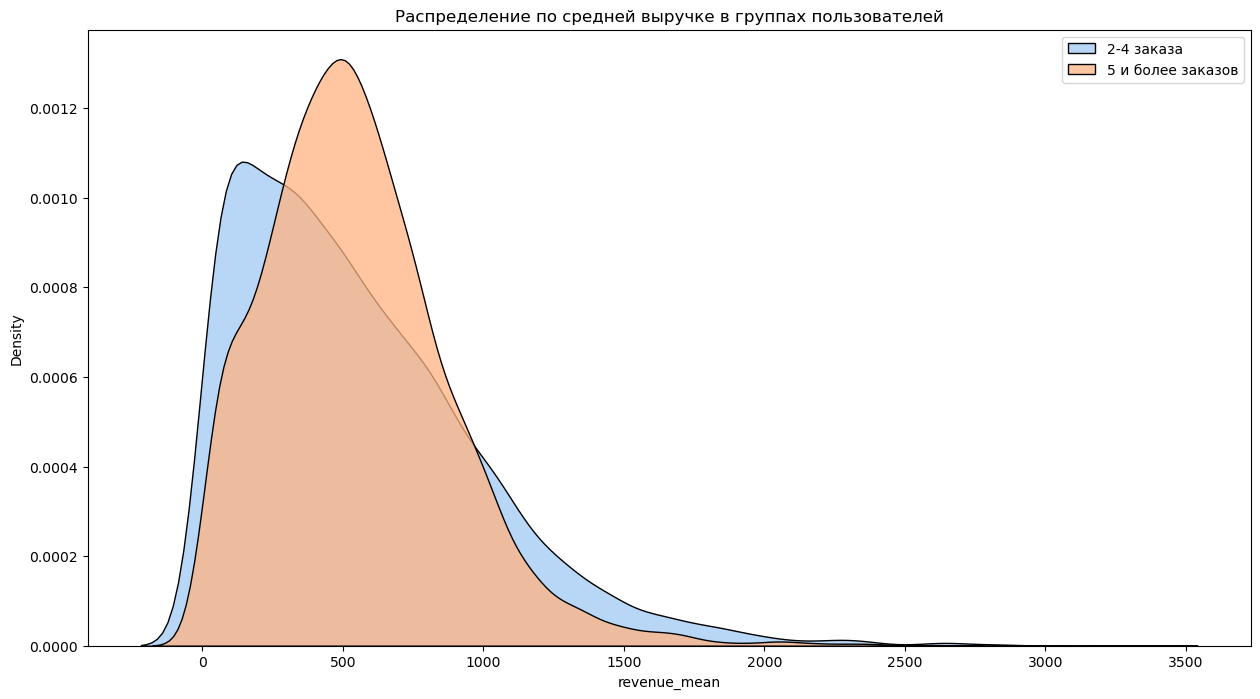

In [97]:
# построим распределения признаков в разрезе кластеров
plt.figure(figsize=(15, 8))
ax = plt.subplot(1, 1, 1)
sns.kdeplot(x='revenue_mean',
            multiple='stack',
            data=df_profile[(df_profile.is_two == 1) & (df_profile.is_five != 1)], ax=ax, label='2-4 заказа')
sns.kdeplot(x='revenue_mean',
            multiple='stack',
            data=df_profile[df_profile.is_five == 1], ax=ax, label='5 и более заказов')
plt.legend()
plt.title('Распределение по средней выручке в группах пользователей')
plt.show()

In [98]:
# Рассчитаем среднюю выручку для групп пользователей по количеству заказов
print('Средняя выручка для пользователей, совершивших 2 - 4 заказа:',\
    (round(df_profile[(df_profile.is_two == 1) & (df_profile.is_five != 1)].revenue_mean.median(),0)), 'рублей')
print('Средняя выручка для для пользователей, совершивших 5+ заказов:',\
    (round(df_profile[df_profile.is_five == 1].revenue_mean.median(),0)), 'рублей')

Средняя выручка для пользователей, совершивших 2 - 4 заказа: 470.0 рублей
Средняя выручка для для пользователей, совершивших 5+ заказов: 516.0 рублей


Для пользователей совершивших 5 и более заказов средняя выручка выше чем для групп пользователей с количеством заказов от 2 до 4.

**Проанализируем влияние среднего количества билетов в заказе на вероятность повторной покупки.**

Изучим распределение пользователей по среднему количеству билетов в заказе.

Разделим пользователей на несколько сегментов по среднему количеству билетов в заказе:
* от 1 до 2 билетов;
* от 2 до 3 билетов;
* от 3 до 5 билетов;
* от 5 и более билетов.
Для каждого сегмента подсчитаем общее число пользователей и долю пользователей, совершивших повторные заказы.

Ответим на вопросы:
Как распределены пользователи по сегментам — равномерно или сконцентрировано?
Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

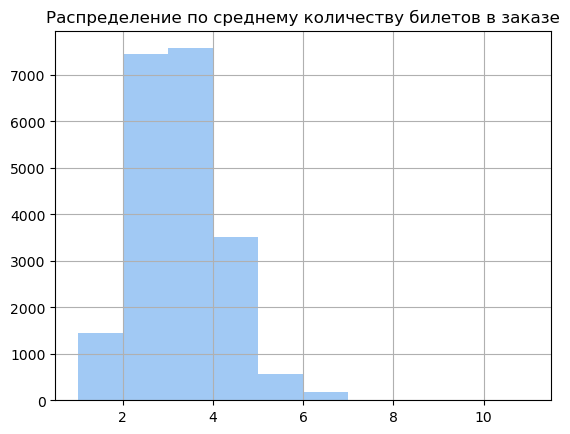

In [99]:
df_profile['tickets_count_mean'].hist(bins=10)
plt.title('Распределение по среднему количеству билетов в заказе')
plt.show()

In [100]:
df_profile.columns

Index(['user_id', 'dt_first_order', 'dt_last_order', 'device_type_first',
       'region_name_first', 'service_name_first', 'event_type_main_first',
       'order_count', 'revenue_mean', 'tickets_count_mean',
       'days_since_prev_mean', 'is_two', 'is_five'],
      dtype='object')

In [101]:
def count_mean_ticket(row):
    if row['tickets_count_mean'] >= 5:
        return 'от 5 и более билетов'
    if row['tickets_count_mean'] >= 3:
        return 'от 3 до 5 билетов'
    if row['tickets_count_mean'] >= 2:
        return 'от 2 до 3 билетов'
    else:
        return 'от 1 до 2 билетов'

df_profile['tickets_count_profile'] = df_profile.apply (count_mean_ticket, axis=1)

In [102]:
df_profile.groupby('tickets_count_profile').agg({'user_id':'count','is_two':'mean','is_five':'mean'}).reset_index().\
rename(columns={'user_id':'Количество пользователей','is_two':'2 и более заказов','is_five':'5 и более заказов'})

,tickets_count_profile,Количество пользователей,2 и более заказов,5 и более заказов
0,от 1 до 2 билетов,1445,0.195848,0.018685
1,от 2 до 3 билетов,7446,0.665055,0.250470
2,от 3 до 5 билетов,11077,0.627607,0.299720
3,от 5 и более билетов,748,0.256684,0.048128


Пользователи сконцентрированы в группе по среднему количеству билетов в заказе от 2 до 5. Эта группа характеризуется высокой долей возврата пользователей за повторными покупками. Потльзователи, совершившие покупку одного билета как правило не возвращаются.

**Исследование временных характеристик первого заказа и их влияния на повторные покупки**

Изучим временные параметры, связанные с первым заказом пользователей:
* день недели первой покупки;
* время с момента первой покупки — лайфтайм;
* средний интервал между покупками пользователей с повторными заказами.

In [103]:
df_profile.columns

Index(['user_id', 'dt_first_order', 'dt_last_order', 'device_type_first',
       'region_name_first', 'service_name_first', 'event_type_main_first',
       'order_count', 'revenue_mean', 'tickets_count_mean',
       'days_since_prev_mean', 'is_two', 'is_five', 'tickets_count_profile'],
      dtype='object')

In [104]:
df_profile['day_week'] = df_profile.dt_first_order.dt.weekday

In [105]:
df_profile['lifetime'] = df_profile.dt_last_order - df_profile.dt_first_order

In [106]:
group_for_wekday = df_profile.groupby('day_week').agg({'user_id':'count','is_two':'mean'}).reset_index()

In [107]:
weekday = {0:'Понедельник',
            1:'Вторник',
            2:'Среда',
            3:'Четверг',
            4:'Пятница', 
            5:'Суббота', 
            6:'Воскресение'}
group_for_wekday['day_week'] = group_for_wekday['day_week'].map(weekday)

In [108]:
group_for_wekday

,day_week,user_id,is_two
0,Понедельник,2815,0.618472
1,Вторник,2993,0.601737
2,Среда,2953,0.608872
3,Четверг,3034,0.583388
4,Пятница,3154,0.586240
5,Суббота,3122,0.602498
6,Воскресение,2645,0.581853


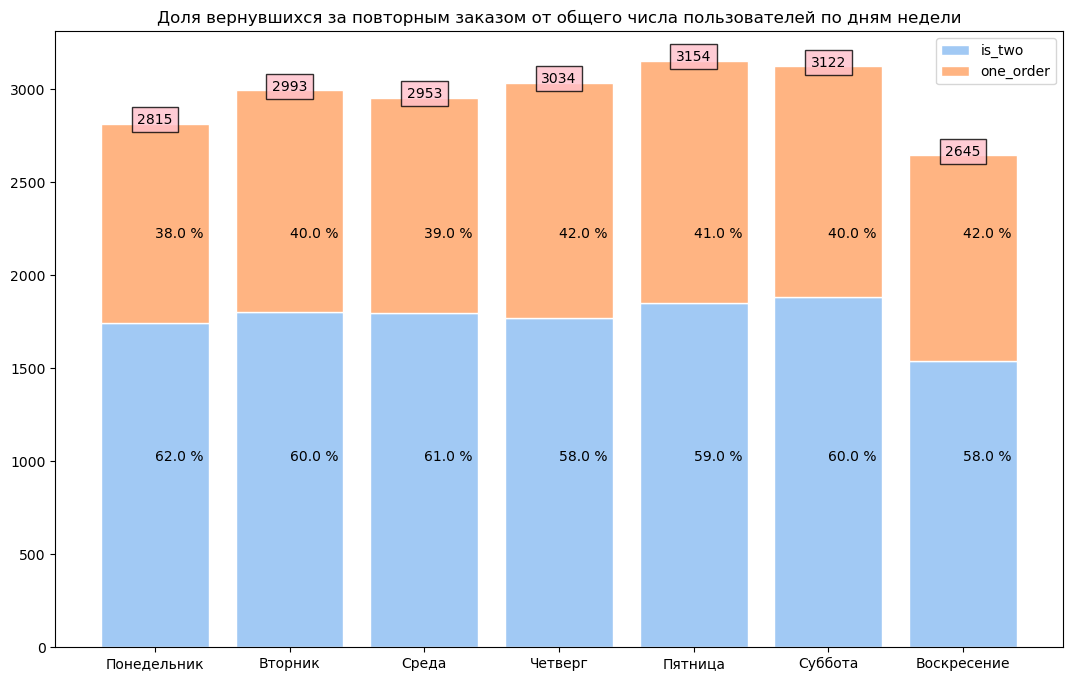

In [109]:
plt.figure(
    figsize=(13, 8)
)
def add_labels(x, y):
    for i in range(len(x)):
        plt.text(i, 1000, r'{} %'.format(y[i]))
plt.bar(group_for_wekday['day_week'], group_for_wekday['is_two']*group_for_wekday['user_id'], label='is_two', edgecolor='#ffffff')
add_labels(group_for_wekday['day_week'], round(group_for_wekday['is_two']*100,0))
def add_labels(x, y):
    for i in range(len(x)):
        plt.text(i, 2200, r'{} %'.format(y[i]))
plt.bar(group_for_wekday['day_week'], (1 - group_for_wekday['is_two'])*group_for_wekday['user_id'],\
        bottom = group_for_wekday['is_two']*group_for_wekday['user_id'], label='one_order', edgecolor='#ffffff')
add_labels(group_for_wekday['day_week'], round((1 - group_for_wekday['is_two'])*100,0))
def add_labels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha='center', bbox=dict(facecolor='pink', alpha=0.8))
add_labels(group_for_wekday['day_week'], group_for_wekday['user_id'])

#plt.xticks(rotation=90)

plt.title("Доля вернувшихся за повторным заказом от общего числа пользователей по дням недели", fontsize=12)
plt.legend()
plt.show()


Максимальный процент пользователей, совершивших повторную покупку, совершили свой первый заказ в понедельник, пользователи, которые совершили свой первый заказ в воскресение совершили повторные заказы в 58% случаев. Тем не менее ярковыраженной зависимости влияния дня недели на вероятность возврата клиента не выявлена.

**Изучим, как средний интервал между заказами влияет на удержание клиентов.**

Рассчитаем среднее время между заказами для двух групп пользователей:
* совершившие 2–4 заказа;
*  совершившие 5 и более заказов.

Исследуем, как средний интервал между заказами влияет на вероятность повторного заказа.

In [110]:
df_profile.columns

Index(['user_id', 'dt_first_order', 'dt_last_order', 'device_type_first',
       'region_name_first', 'service_name_first', 'event_type_main_first',
       'order_count', 'revenue_mean', 'tickets_count_mean',
       'days_since_prev_mean', 'is_two', 'is_five', 'tickets_count_profile',
       'day_week', 'lifetime'],
      dtype='object')

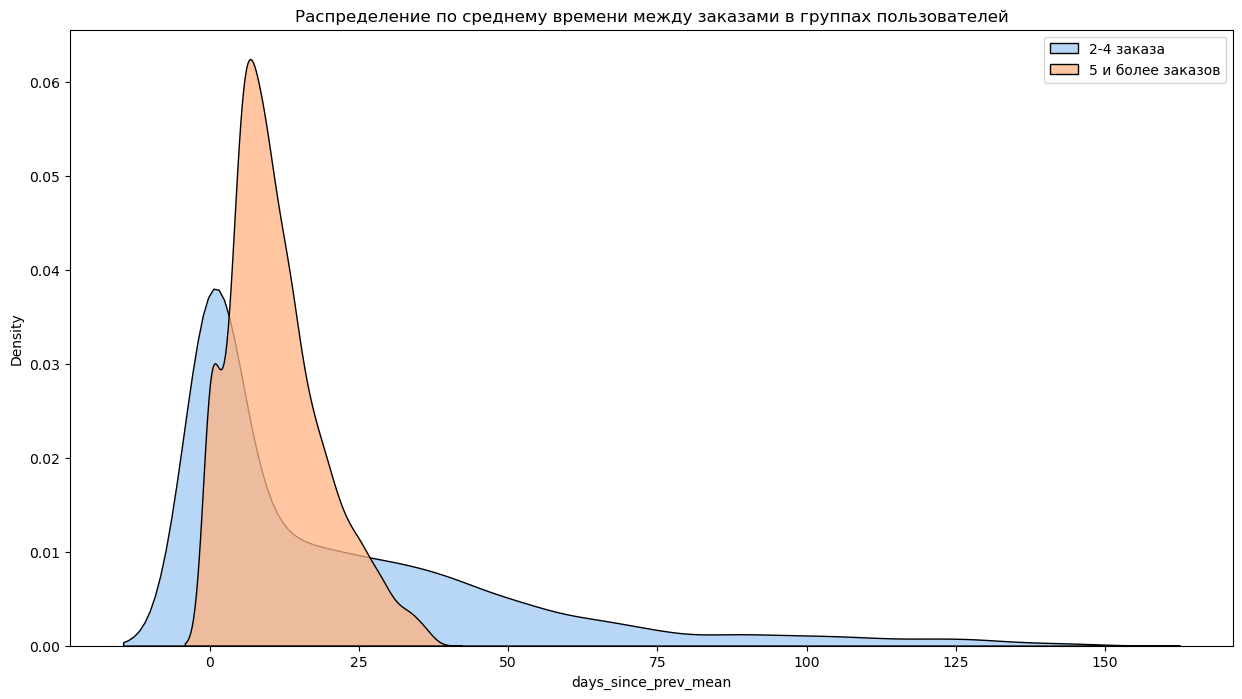

In [111]:
# построим распределения признаков в разрезе кластеров
plt.figure(figsize=(15, 8))
ax = plt.subplot(1, 1, 1)
sns.kdeplot(x='days_since_prev_mean',
            multiple='stack',
            data=df_profile[(df_profile.is_two == 1.0) & (df_profile.is_five != 1.0)], ax=ax, label='2-4 заказа')
sns.kdeplot(x='days_since_prev_mean',
            multiple='stack',
            data=df_profile[df_profile.is_five == 1.0], ax=ax, label='5 и более заказов')
plt.legend()
plt.title('Распределение по среднему времени между заказами в группах пользователей')
plt.show()

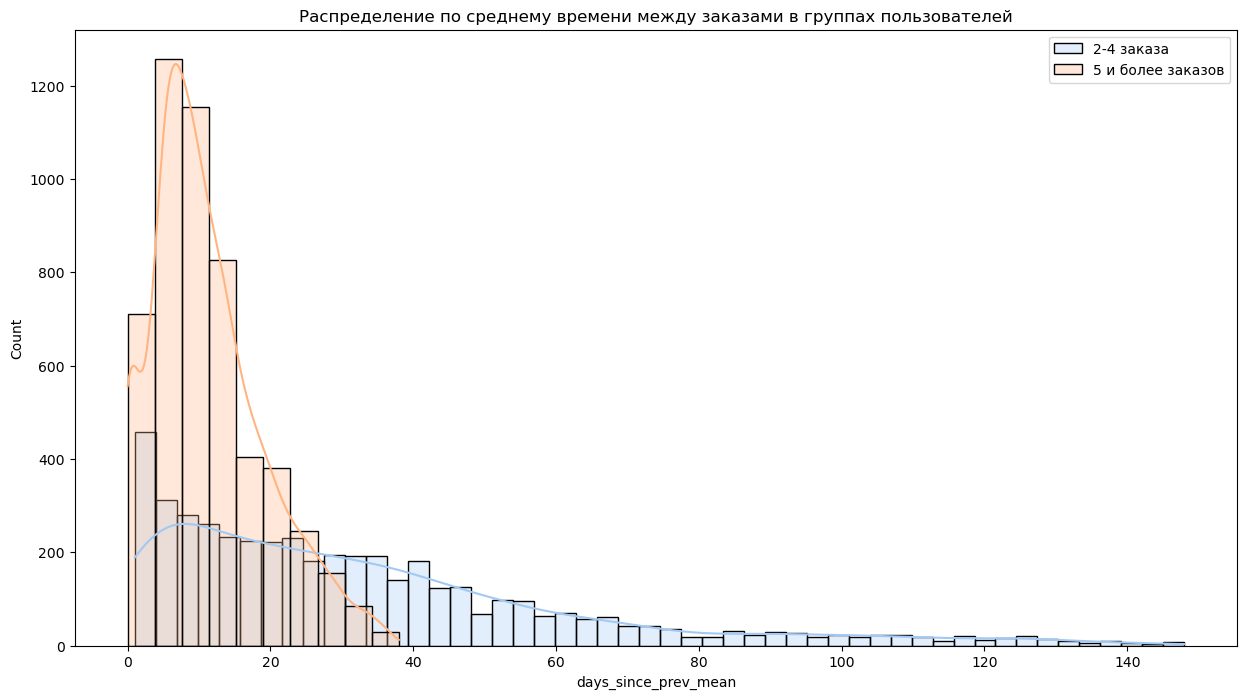

In [112]:
# построим распределения признаков в разрезе кластеров
plt.figure(figsize=(15, 8))
ax = plt.subplot(1, 1, 1)
sns.histplot(x='days_since_prev_mean',
            multiple='stack',
            data=df_profile[(df_profile.is_two == 1.0) & (df_profile.is_five != 1.0)& (df_profile.days_since_prev_mean != 0)], ax=ax, \
             label='2-4 заказа',alpha=0.3,bins=50,kde=True)
sns.histplot(x='days_since_prev_mean',
            multiple='stack',
            data=df_profile[df_profile.is_five == 1.0], ax=ax, label='5 и более заказов',alpha=0.3,bins=10,kde=True)
plt.legend()
plt.title('Распределение по среднему времени между заказами в группах пользователей')
plt.show()

In [113]:
# Рассчитаем среднее время между заказами в группах пользователей по количеству заказов 
print('Среднее время между заказами для пользователей, совершивших 2 - 4 заказа:',\
    (round(df_profile[(df_profile.is_two == 1) & (df_profile.is_five != 1)& (df_profile.days_since_prev_mean != 0)].days_since_prev_mean.mean(),0)), 'дней')
print('Среднее время между заказами для пользователей, совершивших 5+ заказов:',\
    (round(df_profile[df_profile.is_five == 1].days_since_prev_mean.mean(),0)), 'дней')

Среднее время между заказами для пользователей, совершивших 2 - 4 заказа: 33.0 дней
Среднее время между заказами для пользователей, совершивших 5+ заказов: 11.0 дней


 Можно обратить внимание на то, что часть пользователей, совершивших 2 заказа, осуществили его в один и тот же день, так, что среднее время между двумя заказами принято за 0. Фактически, для целей анализа, это можно считать одним заказом.
 Исходя из представленных расчетов, можно сделать вывод - чем короче средний интервал, тем выше шанс, что человек вернется за повторной покупкой.

### **4.3. Корреляционный анализ количества покупок и признаков пользователя**


Изучим, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок.

In [114]:
df_profile.columns

Index(['user_id', 'dt_first_order', 'dt_last_order', 'device_type_first',
       'region_name_first', 'service_name_first', 'event_type_main_first',
       'order_count', 'revenue_mean', 'tickets_count_mean',
       'days_since_prev_mean', 'is_two', 'is_five', 'tickets_count_profile',
       'day_week', 'lifetime'],
      dtype='object')

In [115]:
df_profile.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20716 entries, 0 to 290229
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   user_id                20716 non-null  object         
 1   dt_first_order         20716 non-null  datetime64[ns] 
 2   dt_last_order          20716 non-null  datetime64[ns] 
 3   device_type_first      20716 non-null  object         
 4   region_name_first      20716 non-null  object         
 5   service_name_first     20716 non-null  object         
 6   event_type_main_first  20716 non-null  object         
 7   order_count            20716 non-null  int64          
 8   revenue_mean           20716 non-null  float64        
 9   tickets_count_mean     20716 non-null  float64        
 10  days_since_prev_mean   12402 non-null  float64        
 11  is_two                 20716 non-null  float64        
 12  is_five                20716 non-null  float64    

In [116]:
bins = {'order_count':5, 'revenue_mean':10,'tickets_count_mean':5,'days_since_prev_mean':10,'is_two':2,'is_five':2,'day_week':7}
correlation_matrix = df_profile[['device_type_first',
       'region_name_first', 'service_name_first', 'event_type_main_first',
        'revenue_mean', 'tickets_count_mean',
       'days_since_prev_mean', 'is_two', 'is_five', 'tickets_count_profile',
       'day_week', 'order_count']].\
phik_matrix(interval_cols=['order_count', 'revenue_mean', 'tickets_count_mean', 'days_since_prev_mean', 'is_two', 'is_five', 'day_week'], bins=bins)

In [117]:
correlation_matrix.loc[correlation_matrix.index != 'order_count'][['order_count']].sort_values(by='order_count', ascending=False).round(2)

,order_count
is_five,0.65
days_since_prev_mean,0.41
is_two,0.31
revenue_mean,0.21
tickets_count_mean,0.17
tickets_count_profile,0.11
region_name_first,0.06
service_name_first,0.05
event_type_main_first,0.03
device_type_first,0.02


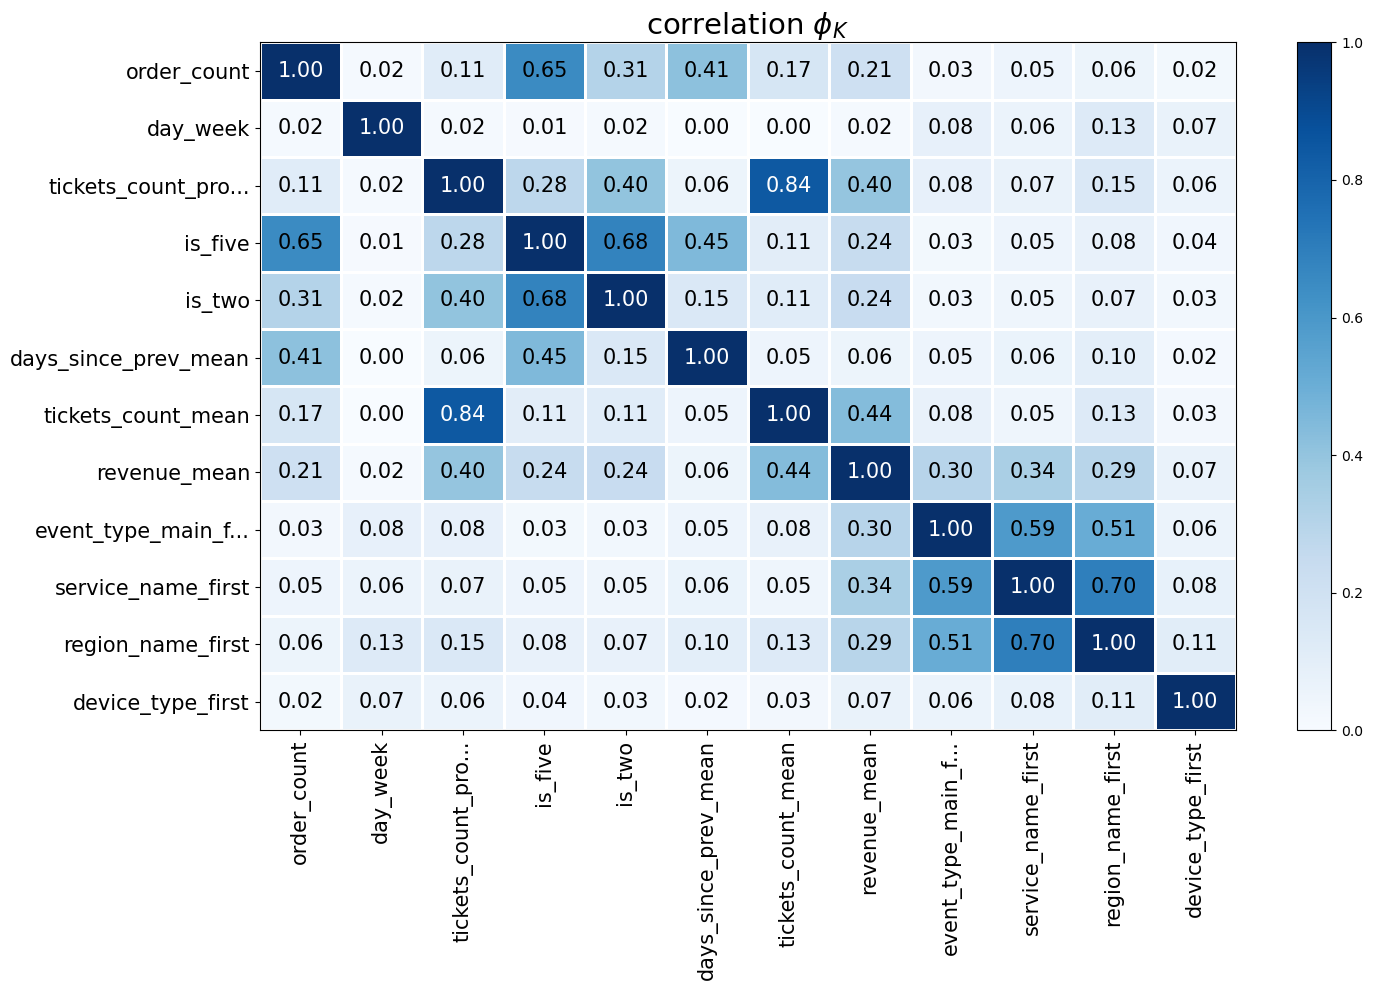

In [118]:
plot_correlation_matrix(correlation_matrix.values, x_labels=correlation_matrix.columns, y_labels=correlation_matrix.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(15,10))
plt.tight_layout()

<Axes: >

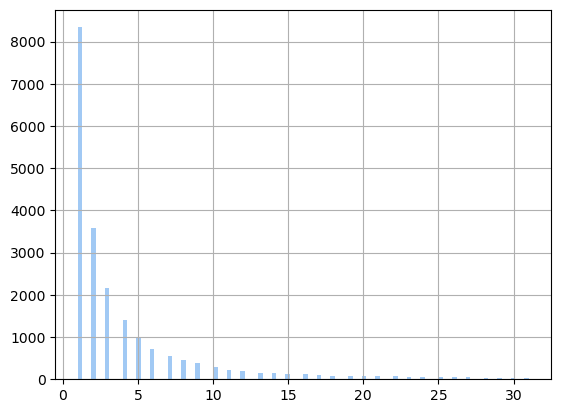

In [119]:
df_profile['order_count'].hist(bins=100)

In [120]:
def order_count(row):
    if row['order_count'] >= 5:
        return 'от 5 и более билетов'
    if row['order_count'] >= 2:
        return 'от 2 до 4 билетов'
    else:
        return '1 билет'

df_profile['order_count_profile'] = df_profile.apply (order_count, axis=1)

In [121]:
def corr_matrics(df):
    bins = {'revenue_mean':10,'tickets_count_mean':5,'days_since_prev_mean':10,'day_week':7}
    correlation_matrix = df[['device_type_first',
           'region_name_first', 'service_name_first', 'event_type_main_first',
            'revenue_mean', 'tickets_count_mean',
           'days_since_prev_mean', 'tickets_count_profile',
           'day_week','order_count']].\
    phik_matrix(interval_cols=['revenue_mean', 'tickets_count_mean', 'days_since_prev_mean', 'day_week'], bins=bins)
    correlation_matrix = correlation_matrix.loc[correlation_matrix.index != 'order_count'][['order_count']].\
    sort_values(by='order_count', ascending=True).round(2)
    return correlation_matrix

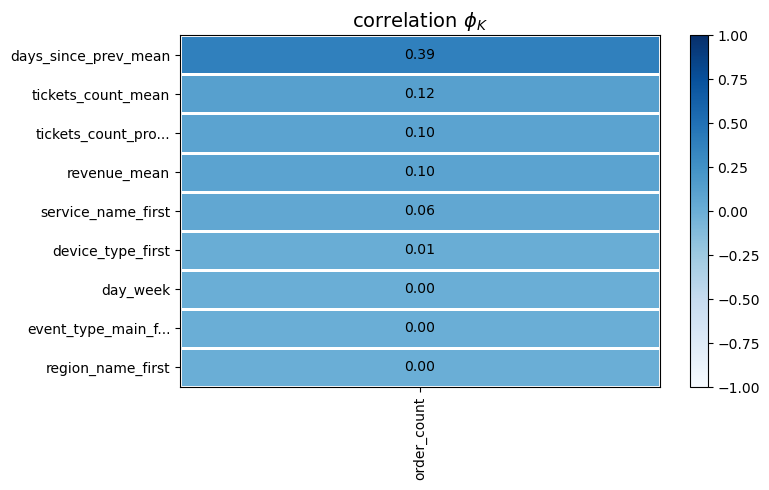

In [122]:
plot_correlation_matrix(corr_matrics(df_profile[df_profile['order_count_profile'] == 'от 2 до 4 билетов']).values,\
                        x_labels=corr_matrics(df_profile[df_profile['order_count_profile'] == 'от 2 до 4 билетов']).columns,\
                        y_labels=corr_matrics(df_profile[df_profile['order_count_profile'] == 'от 2 до 4 билетов']).index, 
                        color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1,
                        figsize=(8,5))
plt.tight_layout()

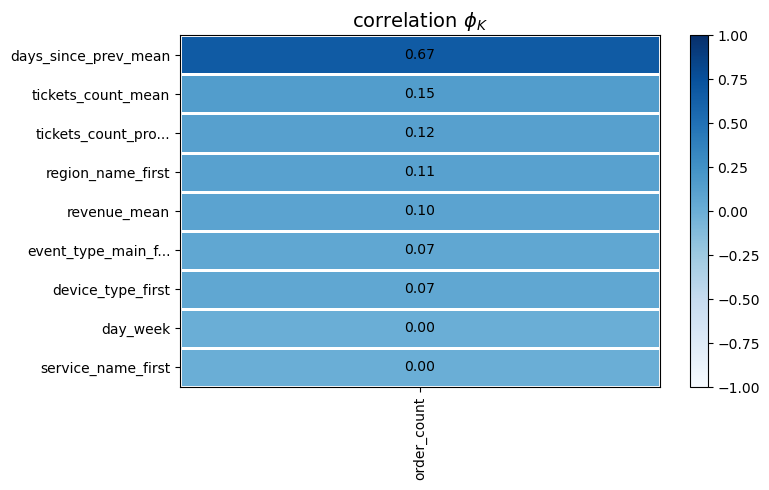

In [123]:
plot_correlation_matrix(corr_matrics(df_profile[df_profile['order_count_profile'] == 'от 5 и более билетов']).values,\
                        x_labels=corr_matrics(df_profile[df_profile['order_count_profile'] == 'от 5 и более билетов']).columns,\
                        y_labels=corr_matrics(df_profile[df_profile['order_count_profile'] == 'от 5 и более билетов']).index, 
                        color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1,
                        figsize=(8,5))
plt.tight_layout()

Наибольшая взаимоствязь с количеством заказов имеет признак среднее время между заказами пользователя. Чем меньше промежутки по времени между заказами, тем более вероятно, что пользователь вернется за покупкой.

## Шаг 5. 
## Общие выводы и рекомендации.

Исследовательский анализ данных показал:
* Данные представлены за все три месяца лета 2024 года и сентябрь-октябрь того же года;
* В данных имеется отрицательная выручка, поэтому они были отфильстрованы по значению выручки, она должна была быть 0 или больше. строки с нулевой выручкой оставлены (1.9 % от общего числа заказов). Явных дубликатов в таблице не обнаружено.
* Часть данных с указанием выручки с заказа представлена в российских рублях, а часть в казахтанских тенге, поэтому для корректного сравнения вся выручка была приведена к валюте - российский рубль, в соответсвии с курсом на дату создания заказа.
* Произведена провека на неявные дубликаты в номинальных данных, дубликатов обнаружено не было.
* Проверка на аномальных значения показала, что выбросы присутствуют как в столбце `tickets_count`, так и в столбце `revenue_rub`.  Для исключения аномальных значений был использован расчет 99 персентиля по столбцу `revenue_rub` и фильтрация по этому значению датафрейма (массив данных сокращен на 1%). После исключения выбросов по выручке, диапазон по количеству билетов в одном заказе не изменился. Количесво билетов в одном заказе вполне разумно - это могут быть гурпповые (корпоративные) мероприятия. Основная часть билетов стоит от 49 до 306 руб, средний чек по билету составляет - 153 руб.
* Построен профиль для 21 809 пользователя. Два и более заказов совершили 62 % пользователей, пять и более заказов - 29% от общего числа пользователей.
* Пользователи с аномальным значением количества заказов для одного пользователя, были исключены из анализа. Максимальное количество заказов, которое мог совершить обычный пользователь составило 32. Итого массив был сокращен на 5 %. В выборке осталось 20 716 пользователей.
* Пользователи были сгруппированны по типу их первого мероприятия, по типу устройства, с которого совершена первая покупка, по региону проведения мероприятия из первого заказа, по билетному оператору, продавшему билеты на первый заказ. Анализ показал, что в основном первые заказы совершены с мобильных телефонов, на концерты, театры и другие мероприятия. Активные заказчики проживают в Каменевском регионе и Североярской области. Самый крупный оператор по продаже билетов - `Билеты без проблем`, через этого оператора совершили первый заказ 27% пользователей.
* Исследованы возвраты клиентов. Гипотезу о том, что пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты и в регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах подтвердить не удалось. Аномально высокие и низкие показатели возрата клиентов в регионах обусловлены малым количеством данных.
* Проведено исследование поведения пользователей через показатели выручки и состава заказа. Для пользователей совершивших 5 и более заказов средняя выручка выше чем для групп пользователей с количеством заказов от 2 до 4 и составляет 470 и 516 руб. соответственно. Пользователи сконцентрированы в группе по среднему количеству билетов в заказе от 2 до 5. Эта группа характеризуется высокой долей возврата пользователей за повторными покупками. Потльзователи, совершившие покупку одного билета как правило не возвращаются. Максимальный процент пользователей, совершивших повторную покупку, совершили свой первый заказ в понедельник, пользователи, которые совершили свой первый заказ в воскресение совершили повторные заказы в 58% случаев. Тем не менее ярковыраженной зависимости влияния дня недели на вероятность возврата клиента не выявлена. Изучение среднего времени между заказами для пользователей показало, что чем короче средний интервал, тем выше шанс, что человек вернется за повторной покупкой.
* Корреляционныйй анализ количества покупок и признаком пользователя показал, что наибольшее влияние на количество покупок оказывает среднее время между покупками пользователя. Чем чаще пользователь совершает покупку, тем больше шанс, что он вернется за ней снова.


На основе выполненного исследовательского анализа данных можно построить ряд рекомендаций по увеличению числа заказов пользователей:
* Чаще напоминать пользователям о возможности заказать билеты, используя сервис по покупке билетов, путем размещения таргетированной рекламы, настроенной на предпочтения каждого конкретного пользователя;
* Предлагать различные промо-акции для привлечения внимания к мероприятиям;
* Реклама билетов к праздникам, на мероприятия подходящих по тематике.